In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/2_EDA

/content/drive/MyDrive/2_EDA


# key eda analysis items

1. regulation type distribution
purpose: which regulation is dominant
analysis: violation_group frequency
expected result:

privacy-related: 70%
competition-related: 20%
consumer-protection: 10%

decision criteria: privacy 60% or more -> finalize the scope as "personal information processing companies"

2. industry distribution
purpose: which industry is data-rich
analysis: sector frequency
expected result:

technology: 40%
healthcare: 25%
finance: 20%
retail: 10%
other: 5%

decision criteria: if the top 2-3 industries are 80% or more -> focus on those industries

3. enforcement pattern by country
purpose: difference in regulatory strictness
analysis: fine_amount_usd mean/median
expected result:

us: average $5m
uk: average $10m
if the difference is 10x or more -> regulatory complexity has discrimination power

decision criteria: if differences between countries are meaningful -> topsis ranking is meaningful

4. time trend
purpose: recent enforcement increase trend
analysis: yearly counts of enforcement_date
expected result:

2017: 50 cases
2024: 300 cases
6x increase -> regulatory tightening trend

decision criteria: if the share concentrated in the last 3 years is 50% or more -> consider using only 2022-2024

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 경로 설정: 6개 국가 CSV 위치
BASE_DIR = Path('/content/drive/MyDrive/2_EDA')
DATA_DIR = BASE_DIR / '2_Final_Usage_Cases_Country'
OUTPUT_DIR = BASE_DIR / 'eda_results'
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("base_dir:", BASE_DIR)
print("data_dir:", DATA_DIR)
print("output_dir:", OUTPUT_DIR)

base_dir: /content/drive/MyDrive/2_EDA
data_dir: /content/drive/MyDrive/2_EDA/2_Final_Usage_Cases_Country
output_dir: /content/drive/MyDrive/2_EDA/eda_results


# 2) data load & required column validation

---


In [4]:
REQUIRED_COLS = [
    "enforcement_id",
    "country_code",
    "company_name",
    "violation_type",
    "enforcement_date",
    "enforcing_agency",
]

COUNTRY_FILES = {
    "us": "1_us_cases.csv",
    "uk": "2_uk_cases.csv",
    "de": "3_de_cases.csv",
    "australia": "4_australia_cases.csv",
    "canada": "5_canada_cases.csv",
    "korea": "6_South_korea_cases.csv",
}

ENCODINGS_TO_TRY = ["utf-8", "utf-8-sig", "latin-1"]


def load_all_countries(dir_path: Path) -> pd.DataFrame:
    if not dir_path.exists():
        raise FileNotFoundError(f"data_dir not found: {dir_path}")

    dfs = []
    failed_files = []

    for country_name, filename in COUNTRY_FILES.items():
        fp = dir_path / filename
        if not fp.exists():
            failed_files.append((country_name, filename, "file not found"))
            continue

        loaded = False
        last_error = None

        for enc in ENCODINGS_TO_TRY:
            try:
                df = pd.read_csv(fp, encoding=enc)
                df["country_name"] = country_name
                df["source_file"] = fp.name
                dfs.append(df)
                loaded = True
                break
            except UnicodeDecodeError as e:
                last_error = f"unicode decode error ({enc})"
            except Exception as e:
                last_error = str(e)
                break

        if not loaded:
            failed_files.append((country_name, filename, last_error or "unknown error"))

    if not dfs:
        details = "\n".join([f"- {c}: {f} ({reason})" for c, f, reason in failed_files]) or "- no files"
        raise ValueError(f"no data files loaded.\n{details}")

    return pd.concat(dfs, ignore_index=True)


def validate_required_columns(df: pd.DataFrame) -> pd.DataFrame:
    missing_cols = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing_cols:
        raise ValueError(f"missing columns: {missing_cols}")

    missing_counts = []
    for c in REQUIRED_COLS:
        na_cnt = int(df[c].isna().sum())

        # empty string check only makes sense for object/string-like columns
        empty_cnt = 0
        if df[c].dtype == "object":
            empty_cnt = int((df[c].astype(str).str.strip() == "").sum())

        missing_counts.append(na_cnt + empty_cnt)

    summary = pd.DataFrame(
        {"column": REQUIRED_COLS, "missing_count": missing_counts}
    ).sort_values("missing_count", ascending=False)

    print("required columns missing values:")
    display(summary)

    return summary


data = load_all_countries(DATA_DIR)
print("rows:", len(data))
print("countries:", sorted(data["country_code"].dropna().unique()))
_ = validate_required_columns(data)

rows: 10997
countries: ['AU', 'CA', 'DE', 'GB', 'KR', 'UK', 'US']
required columns missing values:


,column,missing_count
2,company_name,277
4,enforcement_date,58
3,violation_type,30
0,enforcement_id,2
5,enforcing_agency,1
1,country_code,0


# 3) country distribution

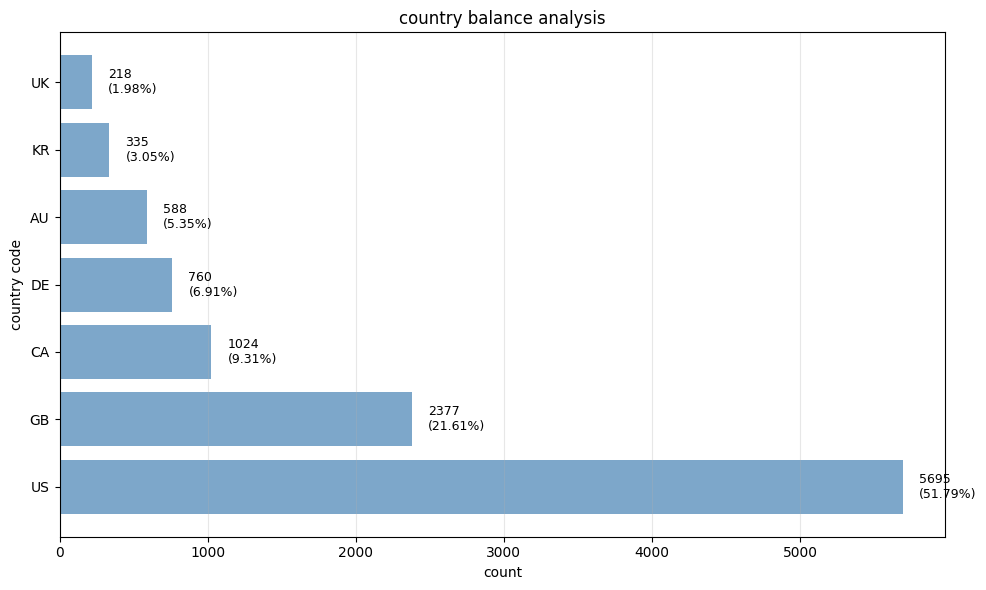

,country_code,n,percentage,cumulative_pct
6,US,5695,51.79,51.79
3,GB,2377,21.61,73.40
1,CA,1024,9.31,82.71
2,DE,760,6.91,89.62
0,AU,588,5.35,94.97


In [5]:
def plot_country_balance(df: pd.DataFrame) -> pd.DataFrame:
    if "country_code" not in df.columns:
        raise ValueError("missing required column: country_code")

    cs = (
        df.groupby("country_code")
        .size()
        .reset_index(name="n")
        .sort_values("n", ascending=False)
    )

    total = int(cs["n"].sum())
    cs["percentage"] = (cs["n"] / total * 100).round(2)
    cs["cumulative_pct"] = cs["percentage"].cumsum().round(2)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(cs["country_code"], cs["n"], color="steelblue", alpha=0.7)

    for i, r in cs.reset_index(drop=True).iterrows():
        ax.text(
            r["n"] + total * 0.01,
            i,
            f"{int(r['n'])}\n({r['percentage']}%)",
            va="center",
            fontsize=9,
        )

    ax.set_xlabel("count")
    ax.set_ylabel("country code")
    ax.set_title("country balance analysis")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return cs


country_summary = plot_country_balance(data)
country_summary.head()

# 4) violation types


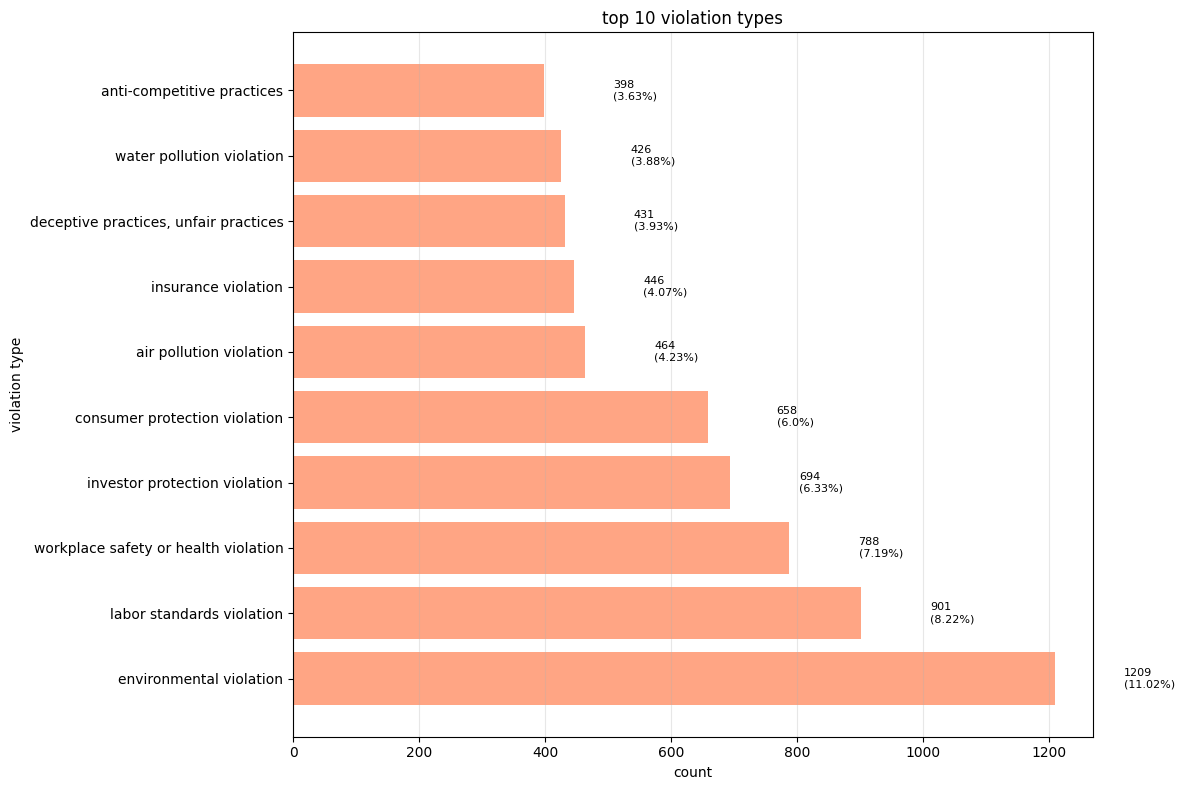

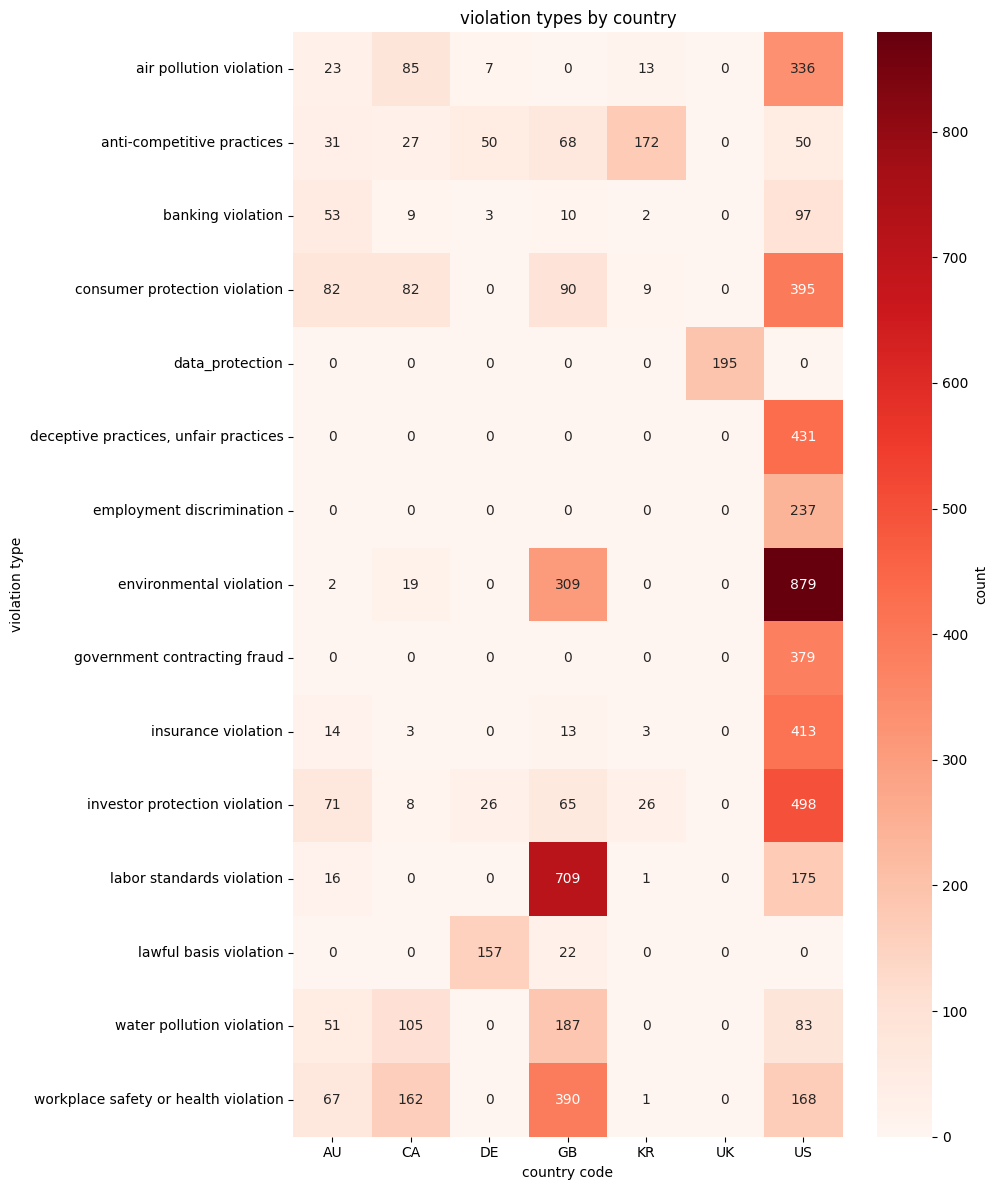

,violation_type,n,percentage,cumulative_pct
0,environmental violation,1209,11.02,11.02
1,labor standards violation,901,8.22,19.24
2,workplace safety or health violation,788,7.19,26.43
3,investor protection violation,694,6.33,32.76
4,consumer protection violation,658,6.00,38.76


In [6]:
def summarize_violation_types(df: pd.DataFrame, top_n_bar: int = 10, top_n_heatmap: int = 15) -> dict:
    required = {"country_code", "violation_type"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"missing required columns: {sorted(missing)}")

    v = df[df["violation_type"].notna() & (df["violation_type"].astype(str).str.strip() != "")].copy()

    vf = v["violation_type"].value_counts().reset_index()
    vf.columns = ["violation_type", "n"]
    total = int(vf["n"].sum())
    vf["percentage"] = (vf["n"] / total * 100).round(2)
    vf["cumulative_pct"] = vf["percentage"].cumsum().round(2)

    # top-n bar
    fig, ax = plt.subplots(figsize=(12, 8))
    top_bar = vf.head(top_n_bar)

    ax.barh(top_bar["violation_type"], top_bar["n"], color="coral", alpha=0.7)
    for i, r in top_bar.reset_index(drop=True).iterrows():
        ax.text(
            r["n"] + total * 0.01,
            i,
            f"{int(r['n'])}\n({r['percentage']}%)",
            va="center",
            fontsize=8,
        )

    ax.set_xlabel("count")
    ax.set_ylabel("violation type")
    ax.set_title(f"top {top_n_bar} violation types")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # heatmap (top-n)
    vbc = (
        v.groupby(["country_code", "violation_type"])
        .size()
        .reset_index(name="n")
    )

    top_list = vf.head(top_n_heatmap)["violation_type"].tolist()
    heatmap_data = (
        vbc[vbc["violation_type"].isin(top_list)]
        .pivot_table(index="violation_type", columns="country_code", values="n", fill_value=0)
        .astype(int)
    )

    plt.figure(figsize=(10, 12))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Reds", cbar_kws={"label": "count"})
    plt.title("violation types by country")
    plt.xlabel("country code")
    plt.ylabel("violation type")
    plt.tight_layout()
    plt.show()

    return {"overall": vf, "by_country": vbc}


viol = summarize_violation_types(data)
viol["overall"].head()

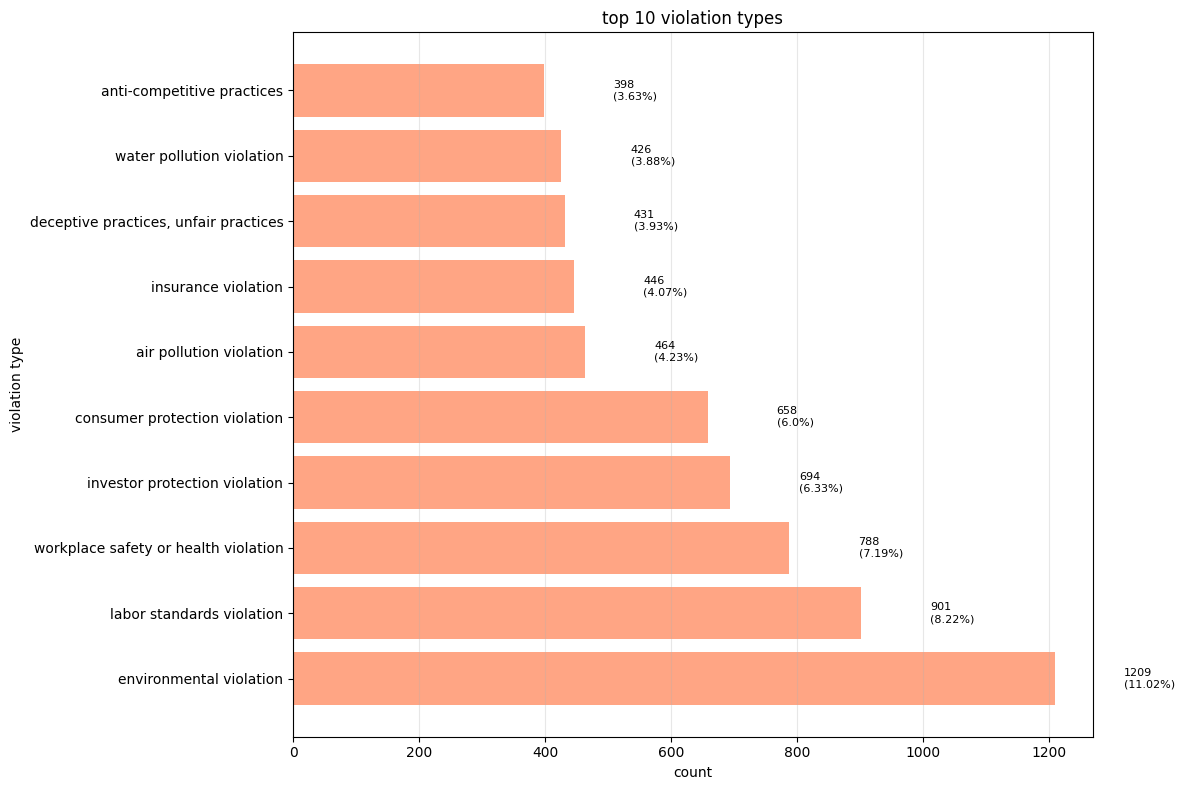

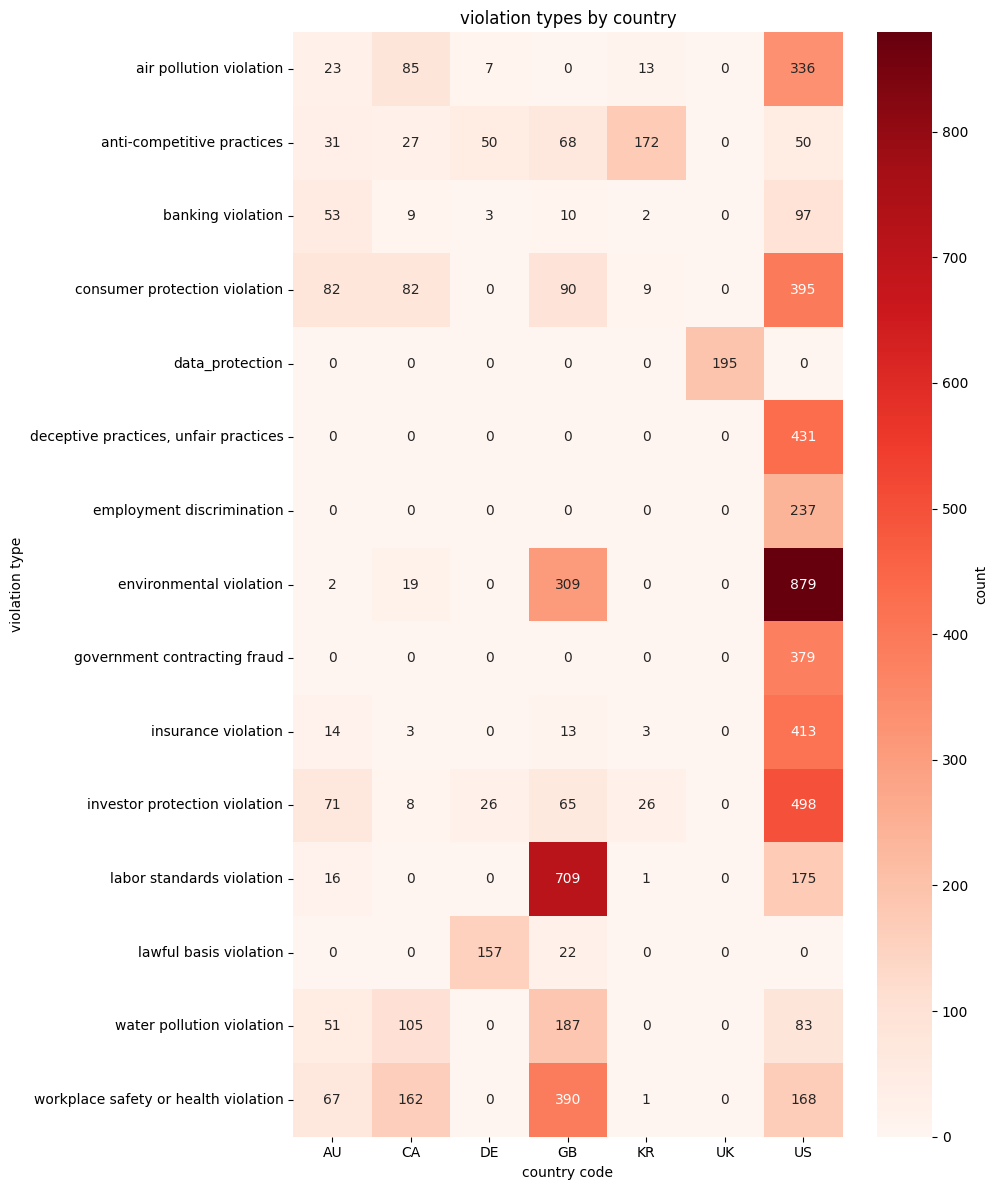

,violation_type,n,percentage,cumulative_pct
0,environmental violation,1209,11.02,11.02
1,labor standards violation,901,8.22,19.24
2,workplace safety or health violation,788,7.19,26.43
3,investor protection violation,694,6.33,32.76
4,consumer protection violation,658,6.00,38.76


In [ ]:
# 위반 유형 빈도/히트맵
def analyze_violation_types(df: pd.DataFrame):
    v = df[df['violation_type'].notna() & (df['violation_type'] != '')].copy()
    vf = v['violation_type'].value_counts().reset_index()
    vf.columns = ['violation_type', 'n']
    vf['percentage'] = (vf['n'] / vf['n'].sum() * 100).round(2)
    vf['cumulative_pct'] = vf['percentage'].cumsum().round(2)

    # top10 bar
    fig, ax = plt.subplots(figsize=(12, 8))
    top10 = vf.head(10)
    ax.barh(top10['violation_type'], top10['n'], color='coral', alpha=0.7)
    for i, r in top10.iterrows():
        ax.text(r['n'] + vf['n'].sum() * 0.01, i,
                f"{int(r['n'])}\n({r['percentage']}%)", va='center', fontsize=8)
    ax.set_xlabel('count')
    ax.set_ylabel('violation type')
    ax.set_title('top 10 violation types')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # heatmap (top15)
    vbc = (
        v.groupby(['country_code', 'violation_type'])
        .size()
        .reset_index(name='n')
    )
    top_list = vf.head(15)['violation_type'].tolist()
    heatmap_data = (
        vbc[vbc['violation_type'].isin(top_list)]
        .pivot_table(index='violation_type', columns='country_code', values='n', fill_value=0)
        .astype(int)
    )
    plt.figure(figsize=(10, 12))
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'count'})
    plt.title('violation types by country')
    plt.xlabel('country code')
    plt.ylabel('violation type')
    plt.tight_layout()
    plt.show()

    return {'overall': vf, 'by_country': vbc}

viol = analyze_violation_types(data)
viol['overall'].head()

# 5) sector

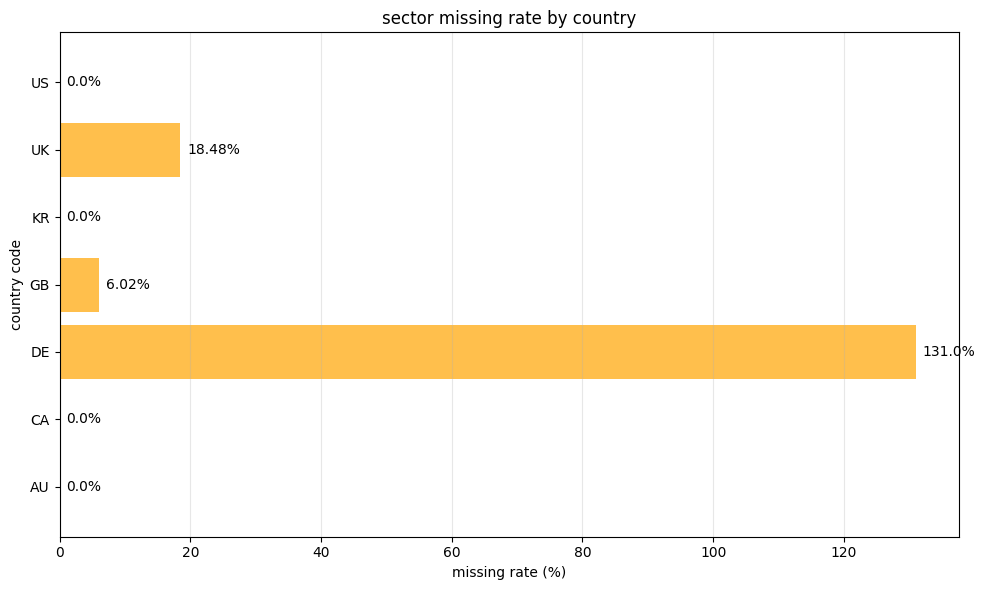

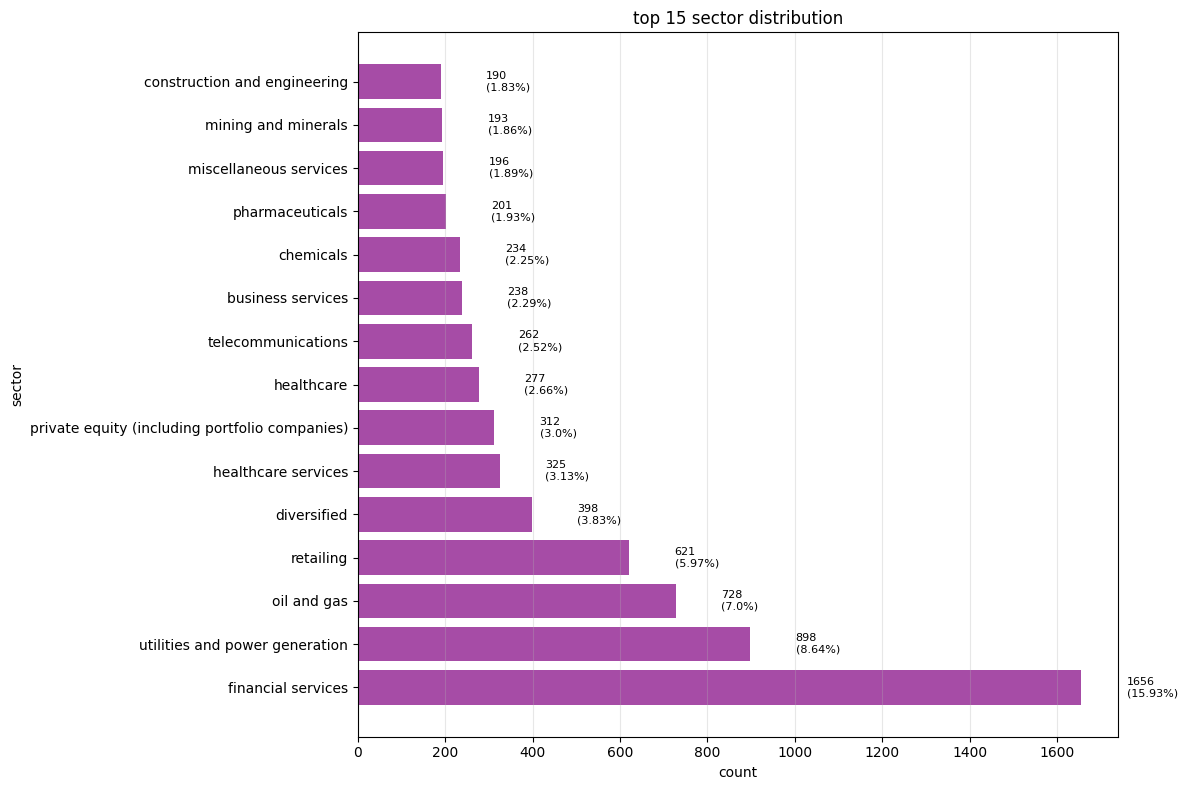

,total,missing,missing_pct,available,available_pct
0,10997,600,5.46,10397,94.54


In [ ]:
# 섹터 결측/분포
def analyze_sector(df: pd.DataFrame):
    total = len(df)
    missing = (df['sector'].isna() | (df['sector'] == '')).sum()
    available = total - missing
    sector_missing = pd.DataFrame({
        'total': [total], 'missing': [missing],
        'missing_pct': [round(missing / total * 100, 2)],
        'available': [available], 'available_pct': [round(available / total * 100, 2)]
    })

    by_cty = (
        df.groupby('country_code')
        .agg(
            total=('sector', 'count'),
            missing=('sector', lambda x: (x.isna() | (x == '')).sum()),
            available=('sector', lambda x: (x.notna() & (x != '')).sum())
        )
        .reset_index()
    )
    by_cty['missing_pct'] = (by_cty['missing'] / by_cty['total'] * 100).round(2)
    by_cty['available_pct'] = (by_cty['available'] / by_cty['total'] * 100).round(2)

    # missing bar
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(by_cty['country_code'], by_cty['missing_pct'], color='orange', alpha=0.7)
    for i, r in by_cty.iterrows():
        ax.text(r['missing_pct'] + 1, i, f"{r['missing_pct']}%", va='center')
    ax.set_xlabel('missing rate (%)')
    ax.set_ylabel('country code')
    ax.set_title('sector missing rate by country')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # distribution
    dist = df[df['sector'].notna() & (df['sector'] != '')]['sector'].value_counts().reset_index()
    dist.columns = ['sector', 'n']
    total_avail = dist['n'].sum()
    dist['percentage'] = (dist['n'] / total_avail * 100).round(2)
    dist['cumulative_pct'] = dist['percentage'].cumsum().round(2)

    fig, ax = plt.subplots(figsize=(12, 8))
    top15 = dist.head(15)
    ax.barh(top15['sector'], top15['n'], color='purple', alpha=0.7)
    for i, r in top15.iterrows():
        ax.text(r['n'] + total_avail * 0.01, i,
                f"{int(r['n'])}\n({r['percentage']}%)", va='center', fontsize=8)
    ax.set_xlabel('count')
    ax.set_ylabel('sector')
    ax.set_title('top 15 sector distribution')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {'missing_summary': sector_missing, 'missing_by_country': by_cty, 'distribution': dist}

sector = analyze_sector(data)
sector['missing_summary']

# 6) date (year)

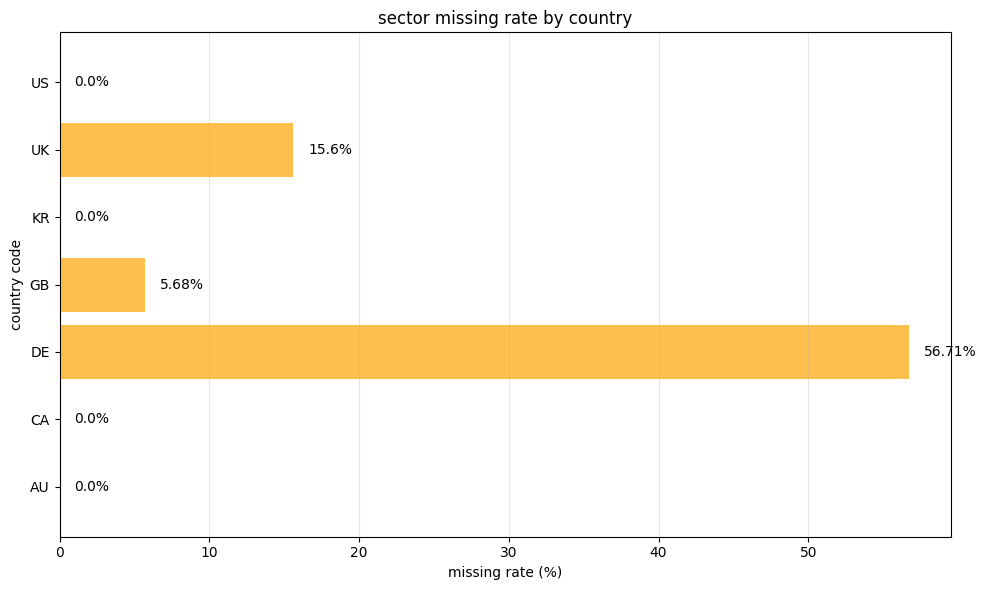

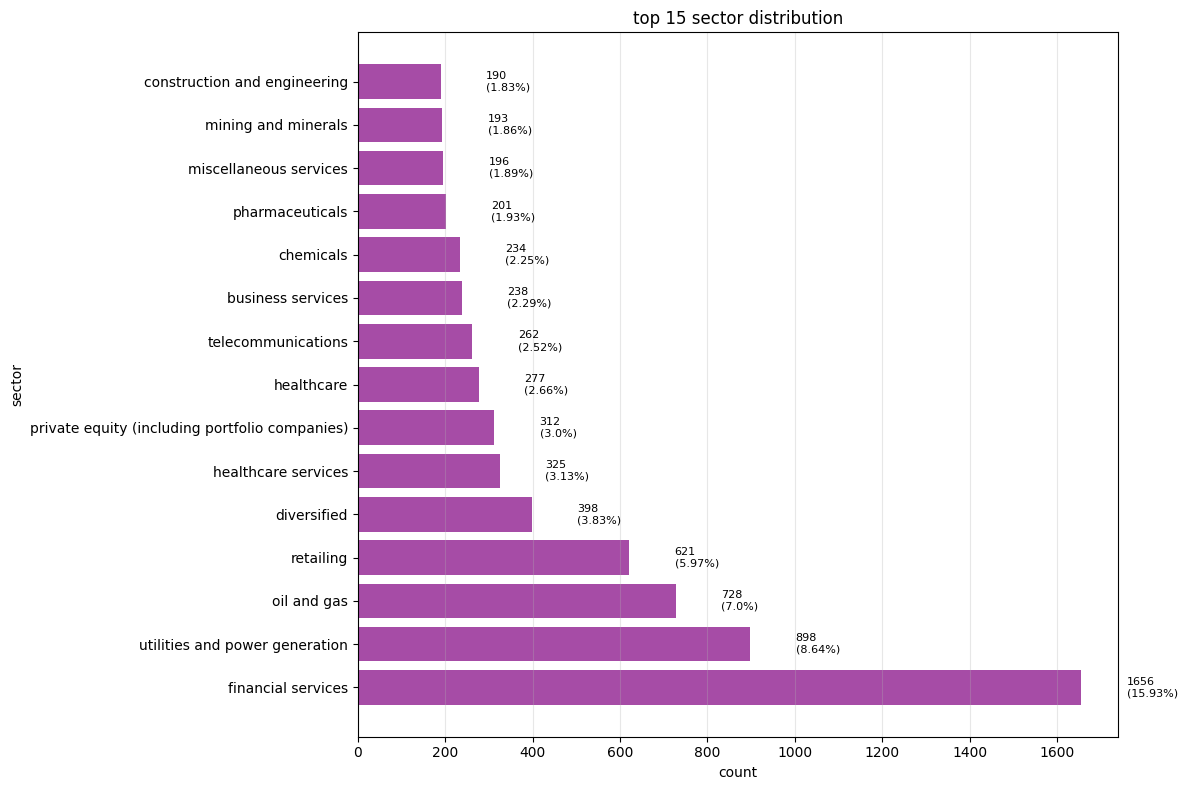

,total,missing,missing_pct,available,available_pct
0,10997,600,5.46,10397,94.54


In [ ]:
def summarize_sector(df: pd.DataFrame, top_n: int = 15) -> dict:
    required = {"country_code", "sector"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"missing required columns: {sorted(missing)}")

    total = int(len(df))

    sector_series = df["sector"]
    is_missing = sector_series.isna() | (sector_series.astype(str).str.strip() == "")
    missing_cnt = int(is_missing.sum())
    available_cnt = total - missing_cnt

    sector_missing = pd.DataFrame(
        {
            "total": [total],
            "missing": [missing_cnt],
            "missing_pct": [round(missing_cnt / total * 100, 2) if total else 0.0],
            "available": [available_cnt],
            "available_pct": [round(available_cnt / total * 100, 2) if total else 0.0],
        }
    )

    by_cty = (
        df.assign(_sector_missing=is_missing)
        .groupby("country_code", dropna=False)
        .agg(
            total=("country_code", "size"),
            missing=("_sector_missing", "sum"),
        )
        .reset_index()
    )
    by_cty["missing"] = by_cty["missing"].astype(int)
    by_cty["available"] = (by_cty["total"] - by_cty["missing"]).astype(int)
    by_cty["missing_pct"] = (by_cty["missing"] / by_cty["total"] * 100).round(2)
    by_cty["available_pct"] = (by_cty["available"] / by_cty["total"] * 100).round(2)

    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(by_cty["country_code"], by_cty["missing_pct"], color="orange", alpha=0.7)
    for i, r in by_cty.reset_index(drop=True).iterrows():
        ax.text(float(r["missing_pct"]) + 1, i, f"{r['missing_pct']}%", va="center")
    ax.set_xlabel("missing rate (%)")
    ax.set_ylabel("country code")
    ax.set_title("sector missing rate by country")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    
    dist = (
        df.loc[~is_missing, "sector"]
        .astype(str)
        .str.strip()
        .value_counts()
        .reset_index()
    )
    dist.columns = ["sector", "n"]
    total_avail = int(dist["n"].sum())
    dist["percentage"] = (dist["n"] / total_avail * 100).round(2) if total_avail else 0.0
    dist["cumulative_pct"] = dist["percentage"].cumsum().round(2)

    fig, ax = plt.subplots(figsize=(12, 8))
    top = dist.head(top_n)
    ax.barh(top["sector"], top["n"], color="purple", alpha=0.7)
    for i, r in top.reset_index(drop=True).iterrows():
        ax.text(
            int(r["n"]) + total_avail * 0.01,
            i,
            f"{int(r['n'])}\n({r['percentage']}%)",
            va="center",
            fontsize=8,
        )
    ax.set_xlabel("count")
    ax.set_ylabel("sector")
    ax.set_title(f"top {top_n} sector distribution")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        "missing_summary": sector_missing,
        "missing_by_country": by_cty,
        "distribution": dist,
    }


sector = summarize_sector(data)
sector["missing_summary"]

# 7) fine

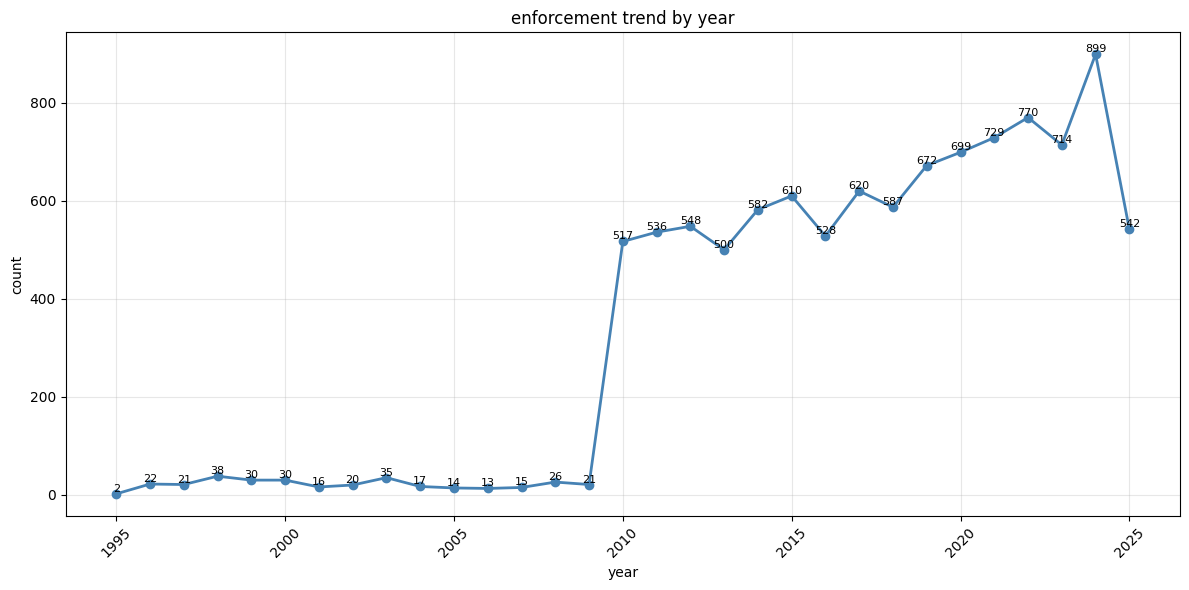

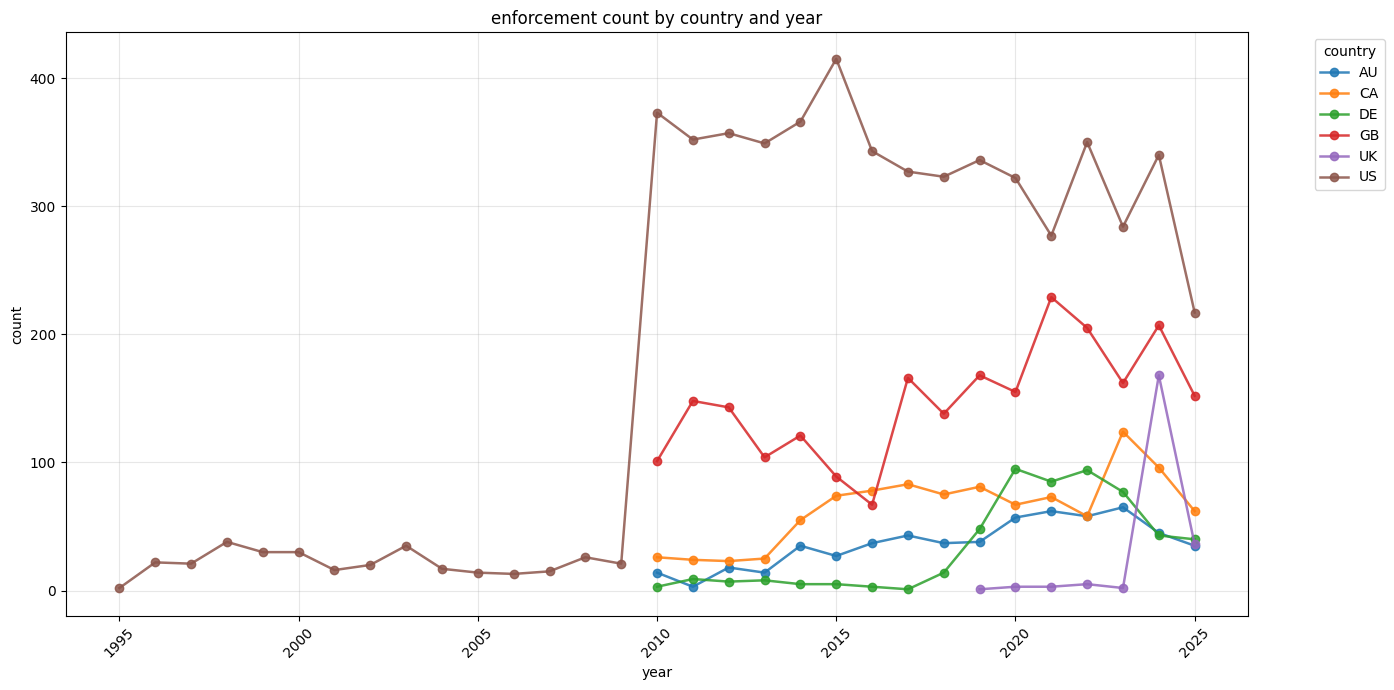

,year,n,percentage,cumulative_pct
0,1995.0,2,0.02,0.02
1,1996.0,22,0.21,0.23
2,1997.0,21,0.20,0.43
3,1998.0,38,0.37,0.80
4,1999.0,30,0.29,1.09


In [8]:
def summarize_enforcement_years(df: pd.DataFrame, recent_from: int = 2020) -> dict:
    required = {"country_code", "enforcement_date"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"missing required columns: {sorted(missing)}")

    d = df.copy()
    d["enforcement_date_parsed"] = pd.to_datetime(d["enforcement_date"], errors="coerce")
    d["year"] = d["enforcement_date_parsed"].dt.year

    total = int(len(d))
    missing_cnt = int(d["enforcement_date_parsed"].isna().sum())
    date_missing = pd.DataFrame(
        {"total": [total], "missing": [missing_cnt], "missing_pct": [round(missing_cnt / total * 100, 2) if total else 0.0]}
    )

    valid = d[d["year"].notna()].copy()
    total_valid = int(len(valid))

    year_dist = (
        valid.groupby("year")
        .size()
        .reset_index(name="n")
        .sort_values("year")
    )
    year_dist["percentage"] = (year_dist["n"] / total_valid * 100).round(2) if total_valid else 0.0
    year_dist["cumulative_pct"] = year_dist["percentage"].cumsum().round(2)

    year_by_cty = (
        valid.groupby(["country_code", "year"])
        .size()
        .reset_index(name="n")
        .sort_values(["country_code", "year"])
    )
    country_tot = year_by_cty.groupby("country_code")["n"].sum().reset_index(name="country_total")
    year_by_cty = year_by_cty.merge(country_tot, on="country_code", how="left")
    year_by_cty["percentage"] = (year_by_cty["n"] / year_by_cty["country_total"] * 100).round(2)

    recent_cnt = int(valid[valid["year"] >= recent_from].shape[0])
    recent_data = pd.DataFrame({"total_valid": [total_valid], "recent_from": [recent_from], "recent": [recent_cnt]})
    recent_data["recent_pct"] = (recent_data["recent"] / recent_data["total_valid"] * 100).round(2) if total_valid else 0.0

    # overall trend
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(year_dist["year"], year_dist["n"], marker="o", color="steelblue", linewidth=2)
    for _, r in year_dist.iterrows():
        ax.text(r["year"], r["n"], f"{int(r['n'])}", ha="center", va="bottom", fontsize=8)
    ax.set_xlabel("year")
    ax.set_ylabel("count")
    ax.set_title("enforcement trend by year")
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # by-country trend (lines)
    fig, ax = plt.subplots(figsize=(14, 7))
    for c, g in year_by_cty.groupby("country_code"):
        ax.plot(g["year"], g["n"], marker="o", linewidth=1.8, alpha=0.85, label=c)
    ax.set_xlabel("year")
    ax.set_ylabel("count")
    ax.set_title("enforcement count by country and year")
    ax.grid(alpha=0.3)
    ax.legend(title="country", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return {
        "missing_summary": date_missing,
        "year_distribution": year_dist,
        "year_by_country": year_by_cty,
        "recent_data": recent_data,
        "data_with_year": d,
    }


dates = summarize_enforcement_years(data, recent_from=2020)
dates["year_distribution"].head()

# after exploring the overall data (step 1)
---
1. issue: violation_type needs to be reclassified. currently,
there are too many (313), so it seems necessary to integrate into 5 categories.

- privacy: data_protection, privacy violation, lawful basis, access request

- competition: anti-competitive practices, monopoly

- consumer: consumer protection, deceptive practices

- environmental: environmental, air pollution, water pollution, waste

- labor: labor standards, workplace safety, employment discrimination

because, during desk research, eu taxonomy (2020) classifies regulations into 5 major categories.
---
and after classification, validation: check whether each category takes 10~20% or more after reclassification

In [9]:
# keep raw column
data["violation_type_raw"] = data["violation_type"]

VIOLATION_KEYWORDS = {
    "privacy": [
        "data_protection", "data protection", "privacy", "lawful basis", "access request",
    ],
    "competition": [
        "anti-competitive", "anticompetitive", "monopoly", "restraint of trade",
    ],
    "consumer": [
        "consumer protection", "deceptive", "unfair practices", "unfair practice",
    ],
    "environmental": [
        "environmental", "air pollution", "water pollution", "waste",
    ],
    "labor": [
        "labor standards", "labour standards", "workplace safety", "employment",
    ],
}


def classify_violation_group(text: str) -> str:
    if pd.isna(text):
        return "other"

    t = str(text).lower()

    for group, keywords in VIOLATION_KEYWORDS.items():
        if any(k in t for k in keywords):
            return group

    return "other"


data["violation_group"] = data["violation_type_raw"].apply(classify_violation_group)

group_counts = (
    data["violation_group"]
    .value_counts(dropna=False)
    .reset_index()
)
group_counts.columns = ["violation_group", "n"]
group_counts["percentage"] = (group_counts["n"] / group_counts["n"].sum() * 100).round(2)

print("violation_group summary:")
display(group_counts)

# validation flags (more interpretable than only 10~20%)
low_share = group_counts[group_counts["percentage"] < 10]
high_share = group_counts[group_counts["percentage"] > 60]

print("\nflags:")
print(f"- groups < 10%: {low_share['violation_group'].tolist()}")
print(f"- groups > 60%: {high_share['violation_group'].tolist()}")

violation_group summary:


,violation_group,n,percentage
0,other,4362,39.67
1,environmental,2359,21.45
2,labor,1943,17.67
3,consumer,1153,10.48
4,privacy,700,6.37
5,competition,480,4.36



flags:
- groups < 10%: ['privacy', 'competition']
- groups > 60%: []


In [10]:
mid_band = group_counts[(group_counts["percentage"] >= 10) & (group_counts["percentage"] <= 20)]
print("\nviolation between 10% and 20%:")
display(mid_band)


violation between 10% and 20%:


,violation_group,n,percentage
2,labor,1943,17.67
3,consumer,1153,10.48


### the issue is that privacy is below 10%, and other is still too high at 40%, so it is necessary to check what the cause is

In [11]:
# other group diagnostics

other_df = data[data["violation_group"] == "other"].copy()

total = len(data)
other_n = len(other_df)
print(f"other rows: {other_n} / {total} ({round(other_n / total * 100, 2)}%)")

# top violation_type_raw in other
other_types = (
    other_df["violation_type_raw"]
    .fillna("")
    .astype(str)
    .str.strip()
    .replace("", "(empty)")
    .value_counts()
    .reset_index()
)
other_types.columns = ["violation_type_raw", "n"]
other_types["percentage_in_other"] = (other_types["n"] / other_types["n"].sum() * 100).round(2)

print("\nother top 30 violation_type_raw:")
display(other_types.head(30))

# where other comes from (by country)
if "country_code" in other_df.columns:
    other_by_country = (
        other_df["country_code"]
        .value_counts()
        .reset_index()
    )
    other_by_country.columns = ["country_code", "n"]
    other_by_country["percentage_in_other"] = (other_by_country["n"] / other_by_country["n"].sum() * 100).round(2)

    print("\nother by country:")
    display(other_by_country)

# quick samples for manual keyword extension
samples = (
    other_df["violation_type_raw"]
    .dropna()
    .astype(str)
    .str.strip()
)
samples = samples[samples != ""].drop_duplicates().head(15).tolist()

print("\nother samples (for keyword update):")
for s in samples:
    print("-", s)

other rows: 4362 / 10997 (39.67%)

other top 30 violation_type_raw:


,violation_type_raw,n,percentage_in_other
0,investor protection violation,694,15.91
1,insurance violation,446,10.22
2,government contracting fraud,379,8.69
3,banking violation,174,3.99
4,telecommunications violation,134,3.07
5,accounting fraud or deficiencies,133,3.05
6,Notes: Date and year are the Findings End Date...,123,2.82
7,Insufficient legal basis for data processing,106,2.43
8,kickbacks and bribery,102,2.34
9,Bid-rigging,102,2.34



other by country:


,country_code,n,percentage_in_other
0,US,2587,59.31
1,GB,558,12.79
2,CA,433,9.93
3,DE,406,9.31
4,AU,242,5.55
5,KR,113,2.59
6,UK,23,0.53



other samples (for keyword update):
- conspiracy
- Civil Penalty (Order Violation)
- Civil Penalty (7a)
- mortgage abuses
- toxic securities abuses
- fraud
- off-label or unapproved promotion of medical products
- kickbacks and bribery
- investor protection violation
- banking violation
- utility safety violation
- anti-money-laundering deficiencies
- government contracting fraud
- PFAS violation
- motor vehicle safety violation


### privacy is low, so it is also necessary to check what the cause is. eda result: data_protection 1.78% + privacy violation 1.31% = 3%. currently it improved to 6.37%, but it is still low.

In [14]:
# privacy quick diagnostics

total = len(data)
privacy_df = data.loc[data["violation_group"] == "privacy"]
print(f"privacy: {len(privacy_df)}/{total} ({round(len(privacy_df) / total * 100, 2) if total else 0.0}%)")

privacy_top10 = privacy_df["violation_type_raw"].value_counts().head(10).reset_index()
privacy_top10.columns = ["violation_type_raw", "n"]
print("\nprivacy top10:")
display(privacy_top10)

privacy_signals = ["gdpr", "personal data", "data breach", "breach", "security", "cookie", "consent", "tracking", "biometric", "surveillance"]

other_df = data.loc[data["violation_group"] == "other"].copy()
mask = other_df["violation_type_raw"].fillna("").astype(str).str.lower().apply(lambda s: any(k in s for k in privacy_signals))
missed_top10 = other_df.loc[mask, "violation_type_raw"].value_counts().head(10).reset_index()
missed_top10.columns = ["violation_type_raw", "n"]
print(f"\nother rows with privacy-like signals: {int(mask.sum())}")
display(missed_top10)

privacy: 700/10997 (6.37%)

privacy top10:


,violation_type_raw,n
0,data_protection,195
1,lawful basis violation,179
2,privacy violation,144
3,access request violation,134
4,deceptive_practice;privacy_violation;security_...,32
5,coppa_violation;deceptive_practice;privacy_vio...,11
6,Insufficient involvement of data protection of...,4
7,data_breach;deceptive_practice;privacy_violati...,1



other rows with privacy-like signals: 60


,violation_type_raw,n
0,Insufficient technical and organisational meas...,53
1,Insufficient fulfilment of data breach notific...,5
2,Company signed a consent agreement to resolve ...,2


In [13]:
# privacy group quick check

total_rows = len(data)
privacy_df = data.loc[data["violation_group"] == "privacy"].copy()
privacy_ratio = round(len(privacy_df) / total_rows * 100, 2) if total_rows else 0.0

print(f"total rows: {total_rows}, privacy rows: {len(privacy_df)}, privacy ratio (%): {privacy_ratio}")

privacy_types = privacy_df["violation_type_raw"].value_counts().head(10).reset_index()
privacy_types.columns = ["violation_type_raw", "n"]
privacy_types["percentage"] = (privacy_types["n"] / privacy_types["n"].sum() * 100).round(2) if len(privacy_types) else 0.0

print("\nprivacy top 10 violation_type_raw:")
display(privacy_types)

total rows: 10997, privacy rows: 700, privacy ratio (%): 6.37

privacy top 10 violation_type_raw:


,violation_type_raw,n,percentage
0,data_protection,195,27.86
1,lawful basis violation,179,25.57
2,privacy violation,144,20.57
3,access request violation,134,19.14
4,deceptive_practice;privacy_violation;security_...,32,4.57
5,coppa_violation;deceptive_practice;privacy_vio...,11,1.57
6,Insufficient involvement of data protection of...,4,0.57
7,data_breach;deceptive_practice;privacy_violati...,1,0.14


### Based on the results, we adopted 6 categories and expanded them further.
Privacy/Competition/Consumer/Labor/Environmental/Financial
add:
Financial: investor, banking, insurance, accounting, securities
Privacy: legal basis, technical measures, GDPR compliance
---
##  Add additional keywords to the second step of reclassifying violation_type and expand by adding more

In [15]:
# violation_type re-mapping (6 categories)

data["violation_type_raw"] = data["violation_type"]

def classify_violation_type(text: str) -> str:
    if pd.isna(text):
        return "other"

    t = str(text).lower()

    if any(k in t for k in [
        "investor", "banking", "insurance", "accounting", "securities",
        "mortgage", "anti-money laundering", "money laundering", "financial",
    ]):
        return "financial"

    if any(k in t for k in [
        "data_protection", "data protection", "privacy", "lawful basis", "access request",
        "legal basis", "technical measures", "special category data", "gdpr", "gdpr compliance",
        "non-compliance with gdpr",
    ]):
        return "privacy"

    if any(k in t for k in [
        "anti-competitive", "anticompetitive", "monopoly", "restraint of trade",
    ]):
        return "competition"

    if any(k in t for k in [
        "consumer protection", "deceptive", "unfair practices", "unfair practice",
    ]):
        return "consumer"

    if any(k in t for k in [
        "environmental", "air pollution", "water pollution", "waste",
    ]):
        return "environmental"

    if any(k in t for k in [
        "labor standards", "labour standards", "workplace safety", "employment",
    ]):
        return "labor"

    return "other"


data["violation_group"] = data["violation_type_raw"].apply(classify_violation_type)

group_counts = data["violation_group"].value_counts().rename_axis("violation_group").reset_index(name="n")
group_counts["percentage"] = (group_counts["n"] / group_counts["n"].sum() * 100).round(2)

print("violation_group summary:")
display(group_counts.sort_values("violation_group"))

mid_group = group_counts[group_counts["percentage"].between(10, 20)]
print("\nviolation groups between 10% and 20%:")
display(mid_group)

violation_group summary:


,violation_group,n,percentage
6,competition,480,4.36
4,consumer,1153,10.48
1,environmental,2359,21.45
3,financial,1550,14.09
2,labor,1943,17.67
0,other,2672,24.30
5,privacy,840,7.64



violation groups between 10% and 20%:


,violation_group,n,percentage
2,labor,1943,17.67
3,financial,1550,14.09
4,consumer,1153,10.48


### it still does not meet the %. and the % for the environmental part is too high, so i need to check this part and decide whether to exclude it or not.
----
- so, how much the data classified as environmental is related to our research target (data/it/global companies)

- what violations are many inside environmental

- country distribution inside environmental


In [16]:
# environmental sensitivity check

data_no_env = data.loc[data["violation_group"] != "environmental"].copy()

print(f"total rows (all): {len(data)}, without environmental: {len(data_no_env)}")

group_no_env = (
    data_no_env["violation_group"]
    .value_counts()
    .rename_axis("violation_group")
    .reset_index(name="n")
)
group_no_env["percentage"] = (group_no_env["n"] / group_no_env["n"].sum() * 100).round(2)

print("\nviolation_group summary without environmental:")
display(group_no_env.sort_values("violation_group"))

# what is inside environmental?
env_df = data.loc[data["violation_group"] == "environmental"].copy()
env_top = env_df["violation_type_raw"].value_counts().head(15).reset_index()
env_top.columns = ["violation_type_raw", "n"]

print("\nenvironmental top 15 violation_type_raw:")
display(env_top)

# environmental by country
env_by_country = env_df["country_code"].value_counts().reset_index()
env_by_country.columns = ["country_code", "n"]

print("\nenvironmental by country:")
display(env_by_country)

total rows (all): 10997, without environmental: 8638

violation_group summary without environmental:


,violation_group,n,percentage
5,competition,480,5.56
3,consumer,1153,13.35
2,financial,1550,17.94
1,labor,1943,22.49
0,other,2672,30.93
4,privacy,840,9.72



environmental top 15 violation_type_raw:


,violation_type_raw,n
0,environmental violation,1209
1,air pollution violation,464
2,water pollution violation,426
3,waste violation,140
4,hazardous waste violation,90
5,solid waste violation,15
6,mining environmental violation,4
7,Allegations of false or misleading environment...,2
8,Allegations of false or misleading environment...,2
9,Allegations of false or misleading environment...,2



environmental by country:


,country_code,n
0,US,1402
1,GB,501
2,CA,297
3,AU,137
4,KR,14
5,DE,8


### final summary about excluding environment
---
- summary of distribution change
- Composition after excluding environmental: other 31%, labor 22%, financial 18%, consumer 13%, privacy 10%, competition 5.6%.
- The privacy ratio reached 10%, making it possible to interpret it as an important axis in research.

- data sufficiency by country
- All countries have more than 200 cases, including 4,293 cases in the US, 1,876 cases in GB, 727 cases in CA, 451 cases in AU, 321 cases in KR, and 752 cases in DE, maintaining a statistically usable level.
- KR·DE has almost no environmental impact (maintained at 96-99%), so there is no problem in comparative analysis by country.

- interpretation with other 31%
- If Environmental is removed, other increases from 24% to 31%, but this proportion can be meaningfully maintained as it can be interpreted as an “Industry-specific” category that contains special regulations for each industry (government procurement, communications, aviation, etc.) other than manufacturing and energy.
---

target and conclusion

:Environmental violations (air, water, and waste) are mainly concentrated in manufacturing, energy, and chemical companies, and have little direct relevance to IT and data-based companies.
Since exceptions such as data center power regulations account for less than 1% of the total and have a small impact, it is reasonable to conclude that excluding Environmental is more appropriate in terms of target consistency and ease of interpretation when targeting data/IT-based companies.

### about excluding labor eda
---


**Final 5 categories remaining**

Competition (5.6%, 480 cases)
Consumer (13.4%, 1,153 cases)
Financial (17.9%, 1,550 cases)
Labor (22.5%, 1,943 cases)
Privacy (9.7%, 840 cases)

Other (31%, 2,672 cases) - Industry-specific regulations

A total of 8,638 cases (excluding 2,359 environmental cases)### final summary about excluding environmental
---
- summary of distribution change
- Composition after excluding environmental: other 31%, labor 22%, financial 18%, consumer 13%, privacy 10%, competition 5.6%.
- The privacy ratio reached 10%, making it possible to interpret it as an important axis in research.

- data sufficiency by country
- All countries have more than 200 cases, including 4,293 cases in the US, 1,876 cases in GB, 727 cases in CA, 451 cases in AU, 321 cases in KR, and 752 cases in DE, maintaining a statistically usable level.
- KR·DE has almost no environmental impact (maintained at 96-99%), so there is no problem in comparative analysis by country.

- interpretation with other 31%
- If Environmental is removed, other increases from 24% to 31%, but this proportion can be meaningfully maintained as it can be interpreted as an “Industry-specific” category that contains special regulations for each industry (government procurement, communications, aviation, etc.) other than manufacturing and energy.
---

target and conclusion

:Environmental violations (air, water, and waste) are mainly concentrated in manufacturing, energy, and chemical companies, and have little direct relevance to IT and data-based companies.
Since exceptions such as data center power regulations account for less than 1% of the total and have a small impact, it is reasonable to conclude that excluding Environmental is more appropriate in terms of target consistency and ease of interpretation when targeting data/IT-based companies.

### about excluding labor eda
---




**Final 5 categories remaining**

Competition (5.6%, 480 cases)
Consumer (13.4%, 1,153 cases)
Financial (17.9%, 1,550 cases)
Labor (22.5%, 1,943 cases)
Privacy (9.7%, 840 cases)

Other (31%, 2,672 cases) - Industry-specific regulations

A total of 8,638 cases (excluding 2,359 environmental cases)



## Currently, there are too many Other 2,672 cases, so they need to be put elsewhere, so for reclassification
---

Things that were in other in the previous EDA

- Financial sector: investor protection, banking, accounting fraud, anti-money laundering, toxic securities, mortgage abuses, etc.
- Privacy series: insufficient legal basis, insufficient technical measures, special category data, non‑compliance with GDPR, etc. Move to privacy
- The remaining other regulations were mainly comprised of industry-specific regulations such as government contracting, telecom, aviation, utilities, and public services.

In [17]:
KEYWORDS = {
    "financial": ["financial", "bank", "securit", "insurance", "mortgage", "tax"],
    "privacy": ["data_protection", "data protection", "privacy", "lawful basis", "access request"],
    "labor": ["labor", "labour", "employment", "workplace", "wage"],
    "consumer": ["consumer", "deceptive", "unfair"],
    "competition": ["anti-competitive", "anticompetitive", "monopoly", "restraint of trade"],
    "environmental": ["environmental", "air pollution", "water pollution", "waste", "emission"],
}

other_text = other_df["violation_type_raw"].fillna("").astype(str).str.lower()

rows = []
denom = len(other_df)

for group, kws in KEYWORDS.items():
    mask = other_text.apply(lambda s: any(k in s for k in kws))
    n = int(mask.sum())
    rows.append({"group": group, "n": n, "percentage": round(n / denom * 100, 2) if denom else 0.0})

other_keyword_summary = pd.DataFrame(rows).sort_values("percentage", ascending=False)

print("other keyword summary (% of other):")
display(other_keyword_summary)

other keyword summary (% of other):


,group,n,percentage
0,financial,805,18.45
2,labor,127,2.91
3,consumer,33,0.76
1,privacy,0,0.00
4,competition,0,0.00
5,environmental,0,0.00


### I think we need to delve deeper into EDA analysis.

- healthcare -> consumer keywords:

"off-label", "controlled substances", "healthcare provider", "medical equipment", "drug"

- tax -> financial keywords:

"tax", "taxation"

In [ ]:
# other deep dive (country / sector / fine / year + operational sectors + country diff)

df = data_final if "data_final" in globals() else data
group_col = "violation_group_refined" if "violation_group_refined" in df.columns else "violation_group"

if group_col not in df.columns:
    raise ValueError(f"missing group column: {group_col}. create violation_group first.")

other_df = df.loc[df[group_col] == "other"].copy()
print(f"total rows: {len(df)}, other rows: {len(other_df)}, other ratio: {len(other_df)/len(df)*100:.2f}%")

# other by country
if "country_code" in other_df.columns:
    other_country = other_df["country_code"].value_counts().rename_axis("country_code").reset_index(name="n")
    other_country["percentage"] = (other_country["n"] / other_country["n"].sum() * 100).round(2)
    print("\nother by country:")
    display(other_country)

# other by sector (top 20)
if "sector" in other_df.columns:
    other_sector = (
        other_df["sector"]
        .fillna("")
        .astype(str)
        .str.strip()
    )
    other_sector = other_sector[other_sector != ""]
    if len(other_sector):
        other_sector = other_sector.value_counts().head(20).rename_axis("sector").reset_index(name="n")
        other_sector["percentage"] = (other_sector["n"] / other_sector["n"].sum() * 100).round(2)
        print("\nother top 20 sectors:")
        display(other_sector)
else:
    print("\nsector column not found")


if "fine_amount_usd" in other_df.columns:
    fine_numeric = pd.to_numeric(other_df["fine_amount_usd"], errors="coerce")
    fine_numeric = fine_numeric[fine_numeric > 0]
    if len(fine_numeric):
        print("\nother fine amount statistics (usd):")
        display(fine_numeric.describe())
    else:
        print("\nno fine data available in other")
else:
    print("\nfine_amount_usd column not found")


if "enforcement_date" in other_df.columns:
    other_year = (
        pd.to_datetime(other_df["enforcement_date"], errors="coerce")
        .dt.year
        .dropna()
        .astype(int)
        .value_counts()
        .sort_index()
        .reset_index()
    )
    other_year.columns = ["year", "n"]
    print("\nother by year (recent 10 years):")
    display(other_year.tail(10))
else:
    print("\nenforcement_date column not found")


operational_sectors = ["utilities", "telecommunications", "freight", "logistics", "airlines", "transportation", "warehousing"]
if "sector" in other_df.columns:
    sector_text = other_df["sector"].fillna("").astype(str).str.lower()
    operational_mask = sector_text.apply(lambda s: any(k in s for k in operational_sectors))
    denom = int((sector_text.str.strip() != "").sum())
    operational_count = int(operational_mask.sum())
    operational_pct = round(operational_count / denom * 100, 2) if denom else 0.0
    print(f"\nother with operational sectors: {operational_count} ({operational_pct}%)")

# std dev
if "country_code" in df.columns:
    country_other = (
        df.groupby("country_code")
        .apply(lambda x: (x[group_col] == "other").sum() / len(x) * 100)
        .round(2)
        .reset_index(name="other_pct")
        .sort_values("other_pct", ascending=False)
    )
    print("\nother percentage by country:")
    display(country_other)
    print(f"\nother percentage std dev: {country_other['other_pct'].std():.2f}")

total rows: 10997, other rows: 2672, other ratio: 24.30%

other by country:


,country_code,n,percentage
0,US,1451,54.30
1,CA,395,14.78
2,GB,379,14.18
3,DE,242,9.06
4,AU,104,3.89
5,KR,80,2.99
6,UK,21,0.79



other top 20 sectors:


,sector,n,percentage
0,utilities and power generation,243,13.93
1,financial services,193,11.07
2,oil and gas,158,9.06
3,pharmaceuticals,140,8.03
4,healthcare services,108,6.19
5,telecommunications,101,5.79
6,retailing,96,5.50
7,aerospace and military contracting,92,5.28
8,private equity (including portfolio companies),92,5.28
9,diversified,72,4.13



other fine amount statistics (usd):


,fine_amount_usd
count,2.296000e+03
mean,6.839022e+07
std,4.571174e+08
min,1.830000e+02
25%,2.050000e+05
50%,1.278702e+06
75%,1.359500e+07
max,1.000000e+10



other by year (recent 10 years):


,year,n
6,2016,141
7,2017,138
8,2018,139
9,2019,166
10,2020,170
11,2021,168
12,2022,187
13,2023,192
14,2024,180
15,2025,132



other with operational sectors: 466 (18.99%)

other percentage by country:


/tmp/ipython-input-2270916895.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x[group_col] == "other").sum() / len(x) * 100)


,country_code,other_pct
1,CA,38.57
2,DE,31.84
6,US,25.48
4,KR,23.88
0,AU,17.69
3,GB,15.94
5,UK,9.63



other percentage std dev: 9.86


## merge the GB/UK name

In [24]:
df['country_code'] = df['country_code'].replace('GB', 'UK')

In [30]:
# country distribution + simple re-weighting check (target=1000)

df = data_final if "data_final" in globals() else data

country_counts = df["country_code"].value_counts().rename_axis("country_code").reset_index(name="n")
country_counts["percentage"] = (country_counts["n"] / country_counts["n"].sum() * 100).round(2)

TARGET = 1000
country_counts["weight"] = (TARGET / country_counts["n"]).round(3)
country_counts["effective_n"] = (country_counts["n"] * country_counts["weight"]).round(1)

print("country distribution:")
display(country_counts[["country_code", "n", "percentage"]].sort_values("n", ascending=False))

print("\ncountry weights (target = 1000):")
display(country_counts[["country_code", "n", "weight", "effective_n"]].sort_values("country_code"))

max_gap = float((country_counts["effective_n"] - TARGET).abs().max())
print(f"\nvalidation: max |effective_n - {TARGET}| = {max_gap}")

country distribution:


,country_code,n,percentage
0,US,5695,51.79
1,UK,2595,23.60
2,CA,1024,9.31
3,DE,760,6.91
4,AU,588,5.35
5,KR,335,3.05



country weights (target = 1000):


,country_code,n,weight,effective_n
4,AU,588,1.701,1000.2
2,CA,1024,0.977,1000.4
3,DE,760,1.316,1000.2
5,KR,335,2.985,1000.0
1,UK,2595,0.385,999.1
0,US,5695,0.176,1002.3



validation: max |effective_n - 1000| = 2.2999999999999545


# to calculate weights by country, to check whether correction is needed because the data is currently imbalanced
---
- for the weight calculation, i apply a calculation formula based on desk research to my project (apply the bholat formula)

- calculation formula
: target = 1000
weight = target / actual count

when calculating with the bholat formula: RC_country = (weight × N + weight × F + D) × coefficients

In [ ]:
import pandas as pd

country_counts = (
    data_final['country_code']
    .value_counts()
    .reset_index()
)
country_counts.columns = ['country_code', 'n']

TARGET = 1000

# 3) 가중치 계산: weight = target / 실제건수
country_counts['weight'] = (TARGET / country_counts['n']).round(3)

# 4) 가중치 적용 시 유효 건수 확인
country_counts['effective_n'] = (country_counts['n'] * country_counts['weight']).round(1)

print("country weights (target = 1000):")
print(country_counts.sort_values('country_code'))

# Compressed goals based on RC scores
---
The purpose of this project is to reclassify 313 complexly scattered violation_types into six regulatory categories based on 8,638 enforcement data from six countries (the US, the UK, Germany, Australia, Canada, and South Korea) and compress the regulatory intensity of each country into a single RC score. The ultimate goal is to create a decision-making support index that allows global companies with complex operations such as logistics, call centers, and manufacturing to compare the regulatory frequency (N), fine severity (F), and violation diversity (D) of each country at a glance and quickly determine which path is more risky or advantageous when entering international markets.

### Why? Are you doing this?
With data currently scattered across countries, regulations, and industries, it's difficult to intuitively compare "which countries are more risky," leading to a reliance on vague experience or consulting fees (ranging from several orders to tens of millions of won). Quantifying regulatory complexity with the RC score allows for a quantitative comparison across six countries based on the same criteria. This allows companies with limited time and budget to quickly narrow down their entry countries based on data (first-stage filtering), and only then invest in detailed consulting or legal review.


## step 1: calculate N, F, D (apply weights)

In [ ]:
# 전제:
# data_final: environmental 제거 후 최종 데이터 (8,638행)
# country_counts: 앞에서 만든 가중치 테이블 (country_code, n, weight)


df = data_final.copy()


df = df.merge(
    country_counts[['country_code', 'weight']],
    on='country_code',
    how='left'
)

df['fine_numeric'] = pd.to_numeric(df['fine_amount_usd'], errors='coerce').fillna(0)

g = df.groupby('country_code')

# N:  weigh
N_raw = g['weight'].sum()

# F: 가중 벌금 합계 weight × fine
F_raw = (df['fine_numeric'] * df['weight']).groupby(df['country_code']).sum()

# D: 카테고리 다양성
def shannon_entropy(sub: pd.DataFrame) -> float:
    counts = sub['violation_group'].value_counts().values
    p = counts / counts.sum()
    return float(-np.sum(p * np.log(p)))

D_raw = g.apply(shannon_entropy)


rc_base = (
    pd.concat([N_raw, F_raw, D_raw], axis=1)
    .reset_index()
)
rc_base.columns = ['country_code', 'N', 'F', 'D']

print("raw N/F/D by country:")
print(rc_base)

## step 2: min-max normalization

In [ ]:
rc_norm = rc_base.copy()

def min_max(series: pd.Series) -> pd.Series:
    s_min = series.min()
    s_max = series.max()
    if s_max == s_min:
        return pd.Series(0.0, index=series.index)
    return (series - s_min) / (s_max - s_min)

rc_norm['N_norm'] = min_max(rc_norm['N'])
rc_norm['F_norm'] = min_max(rc_norm['F'])
rc_norm['D_norm'] = min_max(rc_norm['D'])

print("\nnormalized N/F/D:")
print(rc_norm[['country_code', 'N_norm', 'F_norm', 'D_norm']])

## step 3: calculate rc score

In [ ]:
# 가중치: N 0.4, F 0.3, D 0.3
rc_norm['RC_score'] = (
    0.4 * rc_norm['N_norm'] +
    0.3 * rc_norm['F_norm'] +
    0.3 * rc_norm['D_norm']
)

# 0~1 범위와 순서 확인
rc_result = rc_norm[['country_code', 'RC_score']].copy()
rc_result = rc_result.sort_values('RC_score', ascending=False).reset_index(drop=True)

print("\nRC_score by country (0~1):")
print(rc_result)

## step 4: simple check for validation

In [ ]:
print("\nrc range:", rc_result['RC_score'].min(), "to", rc_result['RC_score'].max())
print("rc sorted descending:")
print(rc_result)

# layer 3 data validation (market + talent + infrastructure)

In [ ]:

vibrancy_path = Path("/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_2_job/pdf_TF_csv_files/ai_vibrancy_ranking_long_format.csv")
vib = pd.read_csv(vibrancy_path)


talent = vib[vib["metric"] == "Al Talent Concentration"].copy()

country_to_iso = {
    "Australia": "AUS",
    "AUS": "AUS",
    "Canada": "CAN",
    "CAN": "CAN",
    "Germany": "DEU",
    "DEU": "DEU",
    "South Korea": "KOR",
    "Korea": "KOR",
    "KOR": "KOR",
    "United Kingdom": "GBR",
    "UK": "GBR",
    "GBR": "GBR",
    "United States": "USA",
    "USA": "USA",
}

def map_country_to_iso(c: str) -> str:
    c = str(c)
    if c in country_to_iso:
        return country_to_iso[c]

    if len(c) == 3:
        return c
    return None

talent["ISO"] = talent["country"].apply(map_country_to_iso)
talent = talent[talent["ISO"].notna()].copy()


idx = talent.groupby("ISO")["year"].idxmax()
talent_latest = talent.loc[idx, ["ISO", "year", "score"]].reset_index(drop=True)
talent_latest = talent_latest.rename(columns={"score": "ai_talent_score_latest"})

print("latest talent score by iso:")
print(talent_latest.sort_values("ISO"), "\n")


prep_path = Path("/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_1_market/AI_Preparedness_Index_Target_Countries_20251215_031628.csv")
prep = pd.read_csv(prep_path)

prep = prep.rename(columns={
    "GDP per capita (current US$)": "gdp_per_capita",
    "Individuals using the Internet (% of population)": "internet_users_pct",
    "Digitial Infrastructure": "digital_infra_index"
})
prep = prep[["ISO", "Country", "gdp_per_capita", "internet_users_pct", "digital_infra_index"]].copy()

final_df = prep.merge(talent_latest, on="ISO", how="left")

output_path = prep_path.parent / "layer3_market_talent_latest.csv"
final_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("layer3 data saved to:", output_path)
print(final_df)

### Layer 3 Verification Results
- Problem 1: AI Talent Unit Confusion
US 0.08, UK 0.00000001 vs CA/DE 32, AU/KR 8
100 million times difference in the same indicator = unit discrepancy

Stanford AI Index original source:

Is it a concentration indicator?
Is it a vibrancy indicator?
Mixing different indicators by country?

- Problem 2: Variable duplication
Including internet_users_pct = 5 variables
Original design: 4 variables (GDP, Talent, Digital, Secure)
Internet needs to be removed

- Issue 3: Missing Secure Servers
Original design: secure_servers_per_million

Current data: None
Reconfirm inclusion in the AI ​​Preparedness Index CSV

- Problem 4: Missing values ​​resolved
UK/US data acquisition complete
Covers all 6 countries

Immediate action

Check the exact metric name in ai_vibrancy_ranking_long_format.csv
2024 AI Talent Concentration Extraction
Remove internet_users_pct
Add secure_servers_per_million

File needs to be re-verified

### 2nd stage processing
- Remove internet_users_pct
- Add secure_servers_per_million
- Correct unit distortion by using the larger value of value/score in Al Talent Concentration

In [ ]:
import pandas as pd

prep = pd.read_csv(
    "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_1_market/AI_Preparedness_Index_Target_Countries_20251215_031628.csv"
)

prep = prep.rename(columns={
    "GDP per capita (current US$)": "gdp_per_capita",
    "Digitial Infrastructure": "digital_infra_index",
    "Secure Internet servers (per 1 million people)": "secure_servers_per_million",
})

prep = prep[["ISO", "Country", "gdp_per_capita", "digital_infra_index", "secure_servers_per_million"]].copy()

print("market/infrastructure columns:")
print(prep, "\n")


vib = pd.read_csv(
    "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_2_job/pdf_TF_csv_files/ai_vibrancy_ranking_long_format.csv"
)

talent_2024 = vib[
    (vib["year"] == 2024) &
    (vib["metric"] == "Al Talent Concentration")
].copy()

# value / score 둘 다 숫자로 변환
talent_2024["value"] = pd.to_numeric(talent_2024["value"], errors="coerce")
talent_2024["score"] = pd.to_numeric(talent_2024["score"], errors="coerce")

# 단위 꼬임 보정: value와 score 중 큰 값을 talent 점수로 사용
talent_2024["talent_raw"] = talent_2024[["value", "score"]].max(axis=1)

country_to_iso = {
    "Australia": "AUS",
    "Canada": "CAN",
    "Germany": "DEU",
    "South Korea": "KOR",
    "Korea": "KOR",
    "United Kingdom": "GBR",
    "UK": "GBR",
    "United States": "USA",
    "USA": "USA",
}

talent_2024["ISO"] = talent_2024["country"].map(country_to_iso)
talent_2024 = talent_2024[talent_2024["ISO"].notna()].copy()


talent_by_iso = (
    talent_2024.groupby("ISO")["talent_raw"]
    .mean()
    .reset_index()
    .rename(columns={"talent_raw": "ai_talent_score_2024"})
)

print("talent score 2024 (fixed):")
print(talent_by_iso, "\n")


final_df = prep.merge(talent_by_iso, on="ISO", how="left")

final_df = final_df[[
    "ISO",
    "Country",
    "ai_talent_score_2024",
    "gdp_per_capita",
    "digital_infra_index",
    "secure_servers_per_million",
]]

out_path = "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_1_market/layer3_market_talent_2024_fixed.csv"
final_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("layer3 data saved to:", out_path)
print(final_df)

### 1 problem discovered
- An outlier was discovered in the US. The AI ​​Talent unit is so strange that we need to suspect a discrepancy. Therefore, we need to verify it.
US 0.080 vs CA 32,000 = 400x difference
UK 32,000 vs. US 0.080 = Reversal (Is the US at the bottom of AI talent?)

In [ ]:

print("talent summary:")
print(final_df["ai_talent_score_2024"].describe())


print("\ntalent by country:")
print(final_df[["ISO", "Country", "ai_talent_score_2024"]])


mean = final_df["ai_talent_score_2024"].mean()
std = final_df["ai_talent_score_2024"].std()

threshold_low = mean - 2 * std
threshold_high = mean + 2 * std

print("\nmean/std:", mean, std)
print("range for normal approx:", threshold_low, "to", threshold_high)

print("\npossible outliers:")
print(
    final_df[
        (final_df["ai_talent_score_2024"] < threshold_low) |
        (final_df["ai_talent_score_2024"] > threshold_high)
    ]
)

# check whether it is possible to use the new kaggle talent data


In [ ]:

data_path = Path("/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_2_job/ai_job_dataset.csv")


df = pd.read_csv(data_path)

print("load ai job dataset")
print("total rows:", len(df))
print("columns:", df.columns.tolist())

### filter 6 target countries

In [ ]:

target_countries = {
    "United States": "US",
    "United Kingdom": "UK",
    "Germany": "DE",
    "Australia": "AU",
    "Canada": "CA",
    "South Korea": "KR",
}

df_6 = df[df["company_location"].isin(list(target_countries.keys()))].copy()
df_6["country_code"] = df_6["company_location"].map(target_countries)

print("rows for six countries:", len(df_6))

country_counts = (
    df_6["country_code"]
    .value_counts()
    .rename_axis("country_code")
    .reset_index(name="job_postings")
)

country_counts["job_postings"] = pd.to_numeric(
    country_counts["job_postings"],
    errors="coerce",
)

country_counts["percentage"] = (
    country_counts["job_postings"] / country_counts["job_postings"].sum() * 100
).round(2)

print("\ncountry distribution:")
print(country_counts.sort_values("country_code"))

### check salary distribution (for checking talent cost)

In [ ]:
# 각 나라별 연봉 수준이 상식과 맞는지 확인
salary_stats = (
    df_6.groupby("country_code")["salary_usd"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .round(2)
)

print("salary statistics by country (usd):")
print(salary_stats.sort_index())

### check remote work ratio (accessibility)

In [ ]:
# 원격 근무 비율이 비슷한지, 나라별 차이가 큰지 확인
remote_stats = (
    df_6.groupby("country_code")["remote_ratio"]
    .agg(["count", "mean"])
    .round(2)
)
remote_stats.columns = ["total_jobs", "avg_remote_ratio"]

print("remote work ratio by country:")
print(remote_stats.sort_index())

### calculate job postings per population (job_postings_per_million)

In [ ]:
# 인구 대비 공고 수는 대략적인 수요 proxy라서, 상식과 맞는지 느낌만 체크
population = {  # 단위: 백만명, 대략값
    "US": 341.8,
    "UK": 67.8,
    "DE": 84.2,
    "AU": 26.5,
    "CA": 40.8,
    "KR": 51.7,
}

job_features = country_counts.copy()
job_features["population_millions"] = job_features["country_code"].map(population)
job_features["job_postings_per_million"] = (
    job_features["job_postings"] / job_features["population_millions"]
).round(2)

print("job postings per million people:")
print(job_features[["country_code", "job_postings", "job_postings_per_million"]].sort_values("country_code"))

### final summary table (a form that can be used later as a layer 3 candidate)

In [ ]:
# 인재 수요 관련 지표 요약: 나중에 layer 3에 쓸 후보
remote_by_country = (
    df_6.groupby("country_code")["remote_ratio"]
    .mean()
    .reset_index()
    .rename(columns={"remote_ratio": "remote_jobs_ratio"})
)

median_salary = (
    df_6.groupby("country_code")["salary_usd"]
    .median()
    .reset_index()
    .rename(columns={"salary_usd": "median_salary_usd"})
)

summary = (
    job_features[["country_code", "job_postings_per_million"]]
    .merge(remote_by_country, on="country_code", how="left")
    .merge(median_salary, on="country_code", how="left")
    .sort_values("country_code")
)

print("ai job market summary (check before using as feature):")
print(summary)

### try to check the independence of variables

In [ ]:

# 1) 기존 Layer3 파일 (이미 만들었던 4개 변수 파일)
layer3_path = Path(
    "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_1_market/layer3_market_talent_2024_fixed.csv"
)

# 2) Kaggle job dataset
jobs_path = Path(
    "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_2_job/ai_job_dataset.csv"
)

layer3 = pd.read_csv(layer3_path)
jobs = pd.read_csv(jobs_path)

print("layer3 columns:", layer3.columns.tolist())
print("jobs columns:", jobs.columns.tolist())

In [ ]:
target_countries = {
    "United States": "US",
    "United Kingdom": "UK",
    "Germany": "DE",
    "Australia": "AU",
    "Canada": "CA",
    "South Korea": "KR",
}

jobs_6 = jobs[jobs["company_location"].isin(list(target_countries.keys()))].copy()
jobs_6["country_code"] = jobs_6["company_location"].map(target_countries)

print("rows for six countries:", len(jobs_6))

# 1) 기본 집계
country_counts = (
    jobs_6["country_code"]
    .value_counts()
    .rename_axis("country_code")
    .reset_index(name="job_postings")
)

# 인구 데이터 (단위: 백만명, 대략값)
population = {
    "US": 341.8,
    "UK": 67.8,
    "DE": 84.2,
    "AU": 26.5,
    "CA": 40.8,
    "KR": 51.7,
}

country_counts["population_millions"] = country_counts["country_code"].map(population)
country_counts["job_postings_per_million"] = (
    country_counts["job_postings"] / country_counts["population_millions"]
).round(2)

# 2) remote_jobs_ratio
remote_by_country = (
    jobs_6.groupby("country_code")["remote_ratio"]
    .mean()
    .reset_index()
    .rename(columns={"remote_ratio": "remote_jobs_ratio"})
)

# 3) median_salary_usd
median_salary = (
    jobs_6.groupby("country_code")["salary_usd"]
    .median()
    .reset_index()
    .rename(columns={"salary_usd": "median_salary_usd"})
)

job_summary = (
    country_counts[["country_code", "job_postings_per_million"]]
    .merge(remote_by_country, on="country_code", how="left")
    .merge(median_salary, on="country_code", how="left")
    .sort_values("country_code")
)

print("job summary:")
print(job_summary)

In [ ]:
# min–max 정규화 함수
def min_max(series: pd.Series) -> pd.Series:
    s_min = series.min()
    s_max = series.max()
    if s_max == s_min:
        return pd.Series(0.0, index=series.index)
    return (series - s_min) / (s_max - s_min)


job_summary["job_postings_norm"] = min_max(job_summary["job_postings_per_million"])
job_summary["remote_norm"] = min_max(job_summary["remote_jobs_ratio"])
job_summary["salary_norm"] = min_max(job_summary["median_salary_usd"])

# Flip it over because it's good if the salary is low
job_summary["salary_score"] = 1 - job_summary["salary_norm"]


job_summary["job_market_index"] = (
    0.4 * job_summary["job_postings_norm"]
    + 0.3 * job_summary["remote_norm"]
    + 0.3 * job_summary["salary_score"]
)

print("job market index:")
print(
    job_summary[
        [
            "country_code",
            "job_postings_per_million",
            "remote_jobs_ratio",
            "median_salary_usd",
            "job_market_index",
        ]
    ].sort_values("country_code")
)

In [ ]:
# layer3의 ISO 코드와 job_summary의 country_code를 매핑
iso_to_country_code = {
    "USA": "US",
    "GBR": "UK",
    "DEU": "DE",
    "AUS": "AU",
    "CAN": "CA",
    "KOR": "KR",
}

layer3["country_code"] = layer3["ISO"].map(iso_to_country_code)

layer3_ext = layer3.merge(
    job_summary[
        [
            "country_code",
            "job_postings_per_million",
            "remote_jobs_ratio",
            "median_salary_usd",
            "job_market_index",
        ]
    ],
    on="country_code",
    how="left",
)

print("merged columns:", layer3_ext.columns.tolist())
print(layer3_ext)

out_path = layer3_path.parent / "layer3_with_job_market.csv"
layer3_ext.to_csv(out_path, index=False, encoding="utf-8-sig")
print("layer3 with job market saved to:", out_path)

In [ ]:

path = Path(
    "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_1_market/layer3_with_job_market.csv"
)

df = pd.read_csv(path)
print("columns:", df.columns.tolist())

cols = [
    "ai_talent_score_2024",
    "gdp_per_capita",
    "digital_infra_index",
    "secure_servers_per_million",
    "job_postings_per_million",
    "remote_jobs_ratio",
    "median_salary_usd",
    "job_market_index",
]

corr = df[cols].corr(method="pearson").round(2)
print("\ncorrelation matrix:")
print(corr)

# for the talent part, it is necessary to do feature engineering by considering supply + demand

In [ ]:
# vibrancy 데이터 경로
vib_path = Path(
    "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/"
    "3_2_job/pdf_TF_csv_files/ai_vibrancy_ranking_long_format.csv"
)

vib = pd.read_csv(vib_path)

print("load vibrancy data")
print("columns:", vib.columns.tolist())

In [ ]:

target_countries = {
    "United States": "USA",
    "United Kingdom": "GBR",
    "Germany": "DEU",
    "Australia": "AUS",
    "Canada": "CAN",
    "South Korea": "KOR",
}

vib_2024 = vib[vib["year"] == 2024].copy()
vib_2024 = vib_2024[vib_2024["country"].isin(target_countries.keys())].copy()
vib_2024["ISO"] = vib_2024["country"].map(target_countries)

print("rows 2024, target countries:", len(vib_2024))
print(vib_2024[["year", "country", "metric"]].head())

### try to extract only 3 metrics based on research

In [ ]:

metrics_for_supply = [
    "Al Publications (Total)",
    "Al Citations (Total)",
    "Notable Al Models",
]

supply_raw = vib_2024[vib_2024["metric"].isin(metrics_for_supply)].copy()


supply_raw["score"] = pd.to_numeric(supply_raw["score"], errors="coerce")

print("rows for supply metrics:", len(supply_raw))
print(supply_raw[["year", "country", "metric", "score"]].head())

### aggregate country averages + pivot

In [ ]:
# ISO, country, metric 기준 평균 score 계산 후 피벗
supply_pivot = (
    supply_raw
    .groupby(["ISO", "country", "metric"])["score"]
    .mean()
    .reset_index()
    .pivot(index=["ISO", "country"], columns="metric", values="score")
    .reset_index()
)

supply_pivot.columns.name = None

print("supply pivot:")
print(supply_pivot)

### min-max normalization + weighted average -> ai_supply_proxy_2024

In [ ]:
def min_max(series: pd.Series) -> pd.Series:
    """0~1 스케일 정규화 (상수열은 0으로 처리)"""
    s_min = series.min()
    s_max = series.max()
    if s_max == s_min:
        return pd.Series(0.0, index=series.index)
    return (series - s_min) / (s_max - s_min)

supply = supply_pivot.copy()
supply["pubs_norm"] = min_max(supply["Al Publications (Total)"])
supply["cites_norm"] = min_max(supply["Al Citations (Total)"])
supply["models_norm"] = min_max(supply["Notable Al Models"])

supply["ai_supply_proxy_2024"] = (
    0.4 * supply["pubs_norm"]
    + 0.3 * supply["cites_norm"]
    + 0.3 * supply["models_norm"]
)

print("ai supply proxy 2024 by country:")
print(
    supply[
        ["ISO", "country", "pubs_norm", "cites_norm", "models_norm", "ai_supply_proxy_2024"]
    ].sort_values("ai_supply_proxy_2024", ascending=False)
)

### Talent features – market-based demand & access (job_market_index)

In [ ]:
jobs_path = Path(
    "/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File/3_2_job/ai_job_dataset.csv"
)

jobs = pd.read_csv(jobs_path)

print("load job dataset")
print("total rows:", len(jobs))
print("columns:", jobs.columns.tolist())

In [ ]:
# 회사 위치 기준 6개국 필터링
job_target_countries = {
    "United States": "US",
    "United Kingdom": "UK",
    "Germany": "DE",
    "Australia": "AU",
    "Canada": "CA",
    "South Korea": "KR",
}

jobs_6 = jobs[jobs["company_location"].isin(job_target_countries.keys())].copy()
jobs_6["country_code"] = jobs_6["company_location"].map(job_target_countries)

print("rows for six countries:", len(jobs_6))

country_counts = (
    jobs_6["country_code"]
    .value_counts()
    .rename_axis("country_code")
    .reset_index(name="job_postings")
)

country_counts["percentage"] = (
    country_counts["job_postings"] / country_counts["job_postings"].sum() * 100
).round(2)

print("\ncountry distribution:")
print(country_counts.sort_values("country_code"))

### calculate job_postings_per_million, remote_jobs_ratio, median_salary_usd

In [ ]:

population = {
    "US": 341.8,
    "UK": 67.8,
    "DE": 84.2,
    "AU": 26.5,
    "CA": 40.8,
    "KR": 51.7,
}

job_features = country_counts.copy()
job_features["population_millions"] = job_features["country_code"].map(population)
job_features["job_postings_per_million"] = (
    job_features["job_postings"] / job_features["population_millions"]
).round(2)

remote_by_country = (
    jobs_6.groupby("country_code")["remote_ratio"]
    .mean()
    .reset_index()
    .rename(columns={"remote_ratio": "remote_jobs_ratio"})
)

median_salary = (
    jobs_6.groupby("country_code")["salary_usd"]
    .median()
    .reset_index()
    .rename(columns={"salary_usd": "median_salary_usd"})
)

job_summary = (
    job_features[["country_code", "job_postings_per_million"]]
    .merge(remote_by_country, on="country_code", how="left")
    .merge(median_salary, on="country_code", how="left")
    .sort_values("country_code")
)

print("job summary raw features:")
print(job_summary)

### Normalization + job_market_index calculation

In [ ]:
def min_max(series: pd.Series) -> pd.Series:
    s_min = series.min()
    s_max = series.max()
    if s_max == s_min:
        return pd.Series(0.0, index=series.index)
    return (series - s_min) / (s_max - s_min)

jm = job_summary.copy()

# 각 피처 정규화
jm["post_norm"] = min_max(jm["job_postings_per_million"])
jm["remote_norm"] = min_max(jm["remote_jobs_ratio"])
jm["salary_norm"] = min_max(jm["median_salary_usd"])

# 연봉은 낮을수록 유리하다고 가정
jm["salary_score"] = 1 - jm["salary_norm"]

# 가중 평균으로 job_market_index 생성 (가중치는 필요 시 조정)
jm["job_market_index"] = (
    0.4 * jm["post_norm"]
    + 0.3 * jm["remote_norm"]
    + 0.3 * jm["salary_score"]
)

print("job market index by country:")
print(
    jm[
        [
            "country_code",
            "job_postings_per_million",
            "remote_jobs_ratio",
            "median_salary_usd",
            "job_market_index",
        ]
    ].sort_values("job_market_index", ascending=False)
)

In [ ]:

target_countries_vib = {
    "Australia": "AUS",
    "Canada": "CAN",
    "Germany": "DEU",
    "South Korea": "KOR",
    "UK": "GBR",
    "USA": "USA",
}

vib_2024 = vib[vib["year"] == 2024].copy()
vib_2024 = vib_2024[vib_2024["country"].isin(target_countries_vib.keys())].copy()
vib_2024["ISO"] = vib_2024["country"].map(target_countries_vib)

print("rows 2024, target countries:", len(vib_2024))
print(vib_2024[["year", "country", "metric"]].head())

In [ ]:
print(sorted(vib_2024["country"].unique()))

In [ ]:
print(
    supply[
        ["ISO", "country", "pubs_norm", "cites_norm", "models_norm", "ai_supply_proxy_2024"]
    ].sort_values("ai_supply_proxy_2024", ascending=False)
)

# 이제 최종 사용하는게 정했졌음 그래서 일단 사용 하는 파일에 대해서 컬럼빼기

In [ ]:

base_dir = Path("/content/drive/MyDrive/2_EDA/3_Part 3_Data_Collection_Total_File")
output_dir = base_dir / "3_1_market"
output_dir.mkdir(exist_ok=True, parents=True)

job_path = base_dir / "3_2_job" / "ai_job_dataset.csv"
df_job = pd.read_csv(job_path)

target_countries_map = {
    "United States": "USA",
    "United Kingdom": "GBR",
    "Germany": "DEU",
    "Australia": "AUS",
    "Canada": "CAN",
    "South Korea": "KOR"
}

df_job_6 = df_job[df_job["company_location"].isin(list(target_countries_map.keys()))].copy()
df_job_6["ISO"] = df_job_6["company_location"].map(target_countries_map)

population = {
    "USA": 341.8,
    "GBR": 67.8,
    "DEU": 84.2,
    "AUS": 26.5,
    "CAN": 40.8,
    "KOR": 51.7
}

job_features = df_job_6.groupby("ISO").agg({
    "job_id": "count",
    "remote_ratio": "mean",
    "salary_usd": "median"
}).reset_index()

job_features.columns = ["ISO", "job_postings", "remote_jobs_ratio", "median_salary_usd"]
job_features["population_millions"] = job_features["ISO"].map(population)
job_features["job_postings_per_million"] = (job_features["job_postings"] / job_features["population_millions"]).round(2)


job_postings_min = job_features["job_postings_per_million"].min()
job_postings_max = job_features["job_postings_per_million"].max()
job_features["job_postings_norm"] = (job_features["job_postings_per_million"] - job_postings_min) / (job_postings_max - job_postings_min)

remote_min = job_features["remote_jobs_ratio"].min()
remote_max = job_features["remote_jobs_ratio"].max()
job_features["remote_norm"] = (job_features["remote_jobs_ratio"] - remote_min) / (remote_max - remote_min)

salary_min = job_features["median_salary_usd"].min()
salary_max = job_features["median_salary_usd"].max()
job_features["salary_inv_norm"] = 1 - ((job_features["median_salary_usd"] - salary_min) / (salary_max - salary_min))

job_features["job_market_index"] = (
    job_features["job_postings_norm"] * 0.4 +
    job_features["remote_norm"] * 0.3 +
    job_features["salary_inv_norm"] * 0.3
).round(4)

talent_data = job_features[["ISO", "job_postings_per_million", "remote_jobs_ratio", "median_salary_usd", "job_market_index"]].copy()


iso_to_country = {
    "USA": "United States",
    "GBR": "United Kingdom",
    "DEU": "Germany",
    "AUS": "Australia",
    "CAN": "Canada",
    "KOR": "South Korea"
}

talent_data["Country"] = talent_data["ISO"].map(iso_to_country)
talent_data = talent_data[["ISO", "Country", "job_postings_per_million", "remote_jobs_ratio", "median_salary_usd", "job_market_index"]].copy()

talent_output_path = output_dir / "talent_job_market_index.csv"
talent_data.to_csv(talent_output_path, index=False, encoding="utf-8-sig")
print(f"talent data saved to: {talent_output_path}")
print(talent_data)

In [ ]:
# 국가별 가중치 계산 (target = 1000)
country_counts = data_final['country_code'].value_counts().reset_index()
country_counts.columns = ['country_code', 'n']
TARGET = 1000
country_counts['weight'] = (TARGET / country_counts['n']).round(3)

country_weights = dict(zip(country_counts['country_code'], country_counts['weight']))
data_final['weight'] = data_final['country_code'].map(country_weights)

# N (가중 빈도)
N_by_country = data_final.groupby('country_code')['weight'].sum().reset_index()
N_by_country.columns = ['country_code', 'N']

# F (가중 벌금)
data_final['fine_numeric'] = pd.to_numeric(data_final['fine_amount_usd'], errors='coerce').fillna(0)
F_by_country = (data_final.groupby('country_code').apply(
    lambda x: (x['fine_numeric'] * x['weight']).sum()
).reset_index())
F_by_country.columns = ['country_code', 'F']

# D (Shannon Entropy)
def calculate_entropy(group):
    violation_counts = group['violation_group'].value_counts()
    probs = violation_counts / violation_counts.sum()
    return -np.sum(probs * np.log(probs + 1e-10))

D_by_country = data_final.groupby('country_code').apply(calculate_entropy).reset_index()
D_by_country.columns = ['country_code', 'D']

# 정규화 및 RC 점수
rc_components = N_by_country.merge(F_by_country, on='country_code').merge(D_by_country, on='country_code')

rc_components['N_norm'] = (rc_components['N'] - rc_components['N'].min()) / (rc_components['N'].max() - rc_components['N'].min())
rc_components['F_norm'] = (rc_components['F'] - rc_components['F'].min()) / (rc_components['F'].max() - rc_components['F'].min())
rc_components['D_norm'] = (rc_components['D'] - rc_components['D'].min()) / (rc_components['D'].max() - rc_components['D'].min())

rc_components['RC_score'] = (
    rc_components['N_norm'] * 0.4 +
    rc_components['F_norm'] * 0.3 +
    rc_components['D_norm'] * 0.3
).round(6)

# ISO 매핑 및 저장
iso_mapping = {"US": "USA", "UK": "GBR", "DE": "DEU", "CA": "CAN", "AU": "AUS", "KR": "KOR"}
rc_scores = rc_components[['country_code', 'RC_score']].copy()
rc_scores['ISO'] = rc_scores['country_code'].map(iso_mapping)
rc_scores = rc_scores[['ISO', 'RC_score']].copy()

rc_output_path = output_dir / "rc_scores.csv"
rc_scores.to_csv(rc_output_path, index=False, encoding="utf-8-sig")
print(f"rc scores saved to: {rc_output_path}")
print(rc_scores)

rc scores saved to: /content/drive/MyDrive/2_EDA/rc_scores.csv
   ISO  RC_score
0  AUS  0.254748
1  CAN  0.422046
2  DEU  0.111091
3  KOR  0.145060
4  GBR  0.591713
5  USA  0.750986
